In [121]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN, AgglomerativeClustering

import scipy.stats as stats
from scipy.stats import pearsonr

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from pymorphy3 import MorphAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Вид таблицы:


,brand_id,date,receipts_count
1,178,2016-07-01,234
4,178,2016-07-02,185
7,178,2016-07-03,190
10,178,2016-07-04,196
13,178,2016-07-05,336


----------------------------------------------------------------
Тип данных:
<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 457
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        153 non-null    int64         
 1   date            153 non-null    datetime64[ns]
 2   receipts_count  153 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 KB


None

----------------------------------------------------------------
Основные ститистики по таргету:


count    153.000000
mean     327.045752
std      134.810703
min      143.000000
25%      227.000000
50%      275.000000
75%      399.000000
max      712.000000
Name: receipts_count, dtype: float64

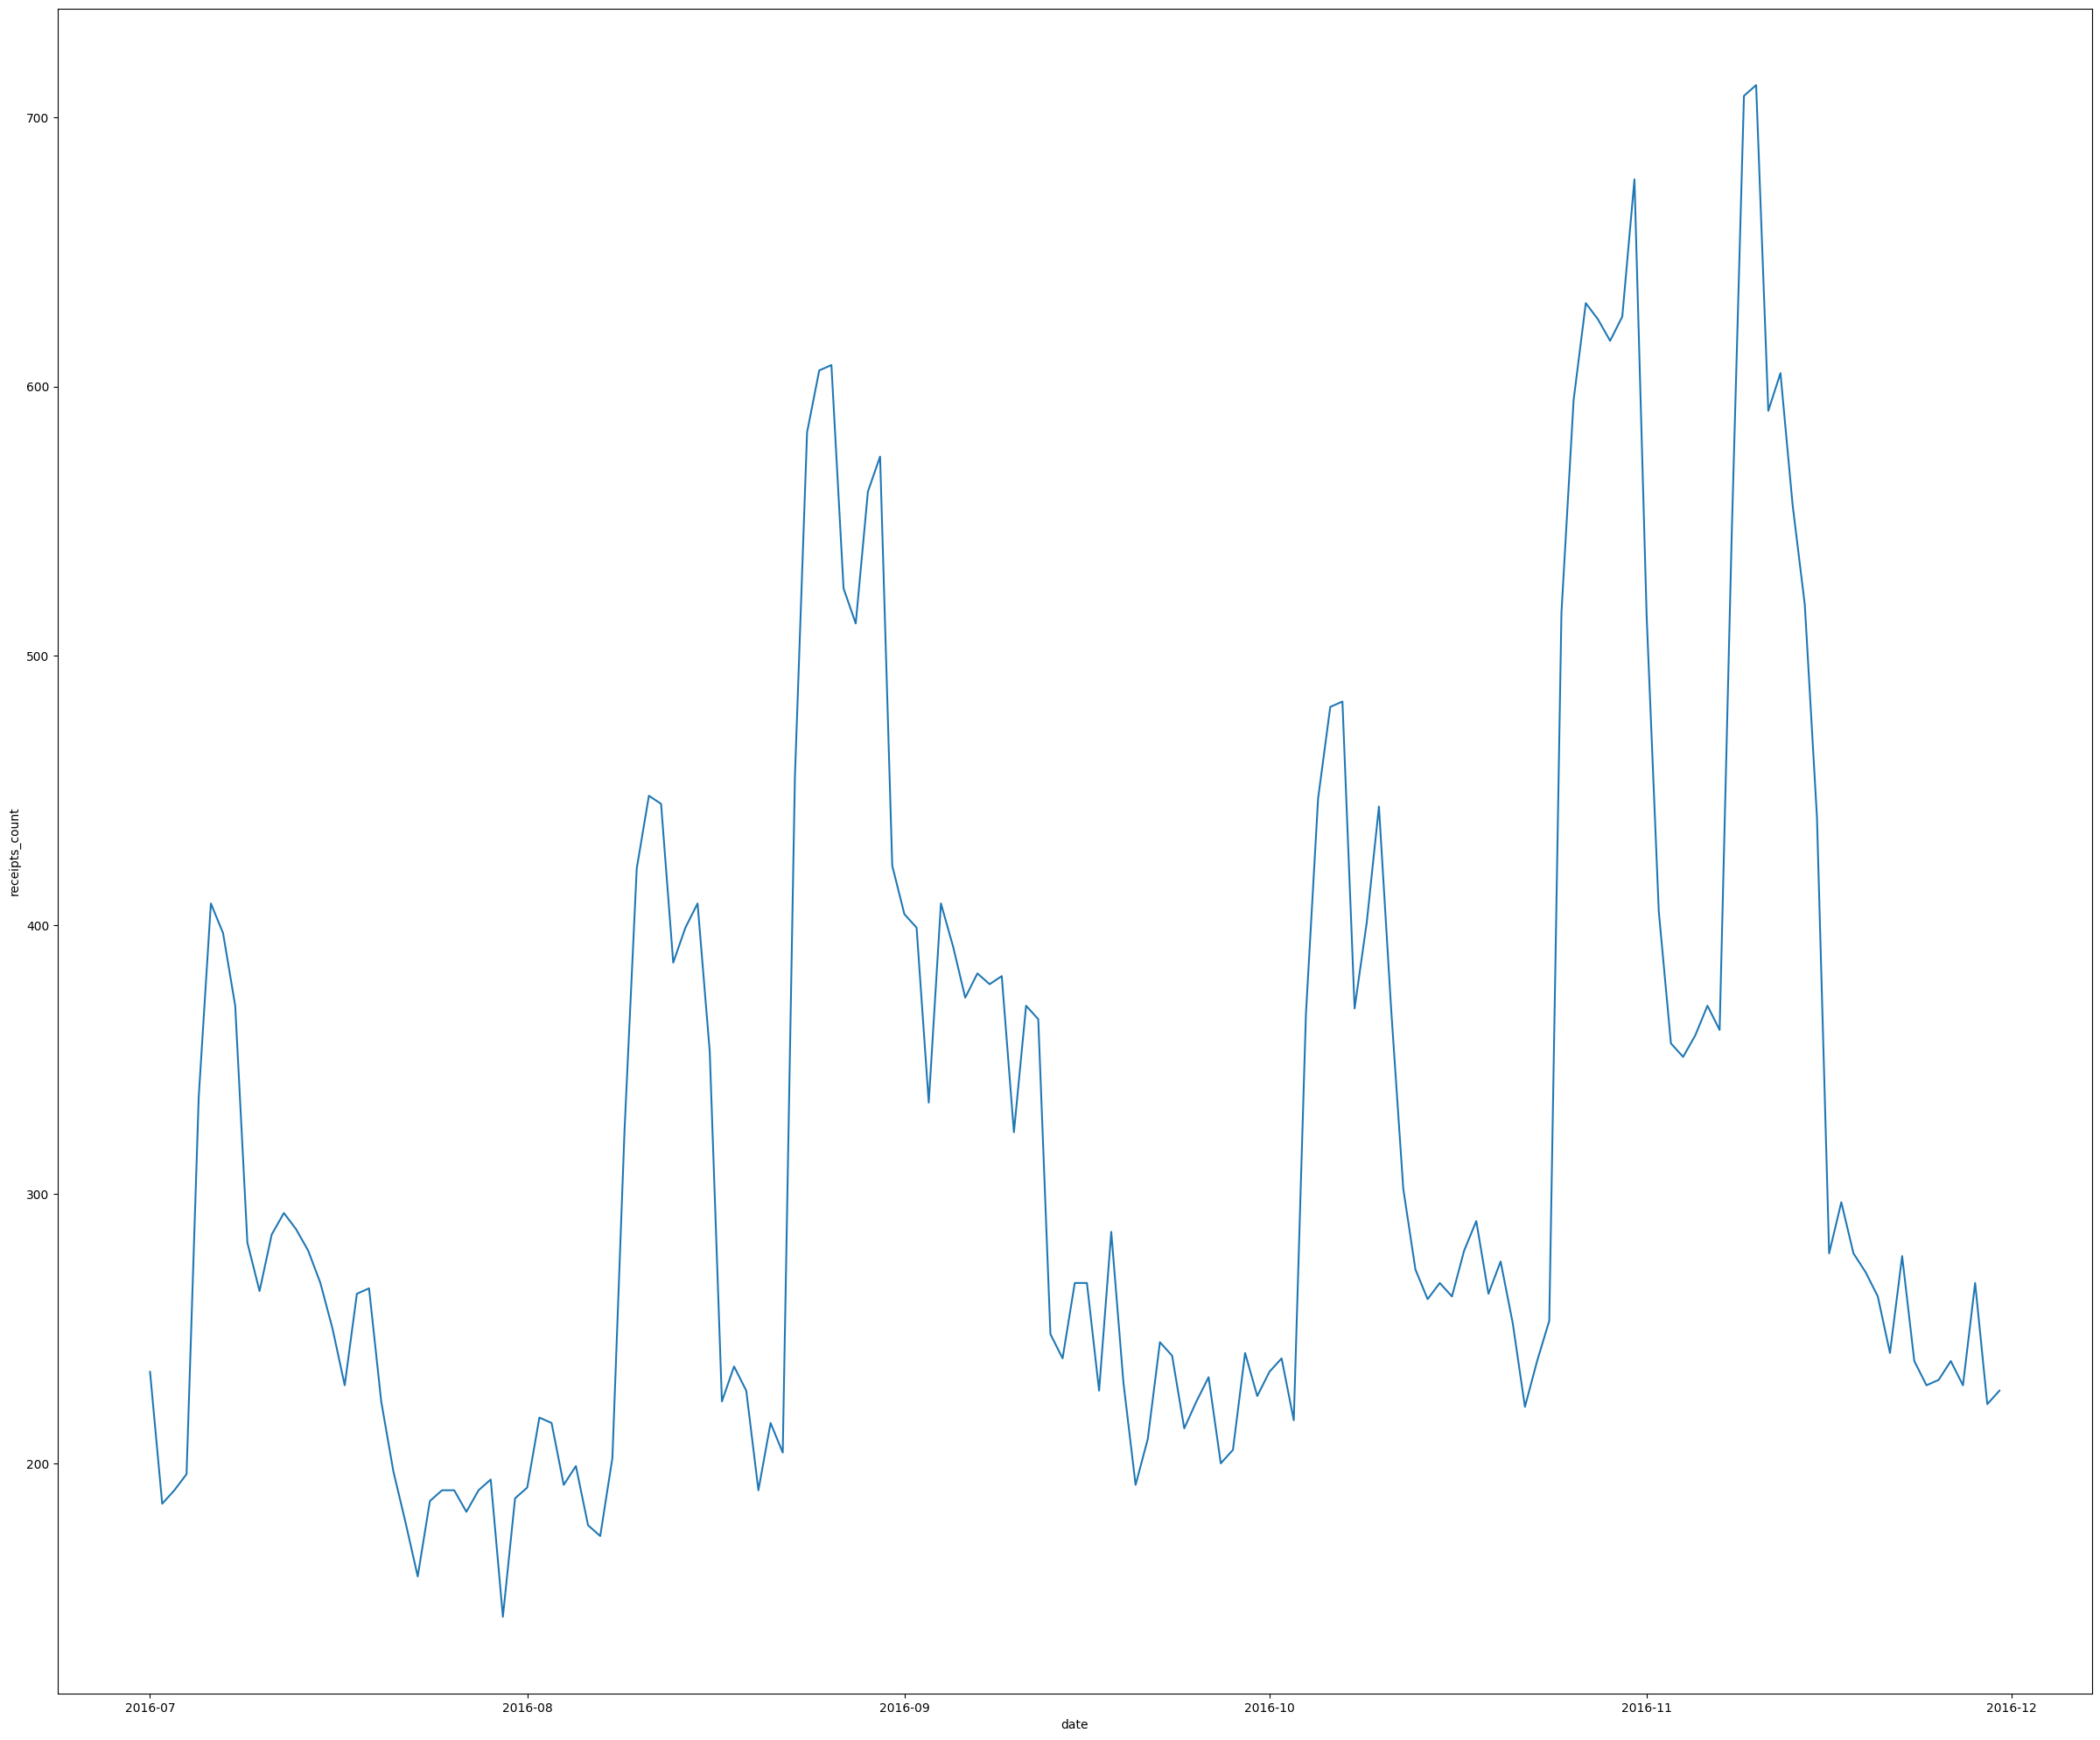

In [122]:
data_raw = pd.read_csv("data/tea_demand.csv", sep="\t", parse_dates=["date"])


data = data_raw[data_raw["brand_id"] == 178]

print("Вид таблицы:")
display(data.head())
print('----------------------------------------------------------------')
print("Тип данных:")
display(data.info())
print('----------------------------------------------------------------')
print("Основные ститистики по таргету:")
display(data["receipts_count"].describe())

# Построим график
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

barplot_sells = sns.lineplot(x=data["date"], y=data["receipts_count"])

plt.show()

----
### Спарсим информацию по датам проведения программы Что, Где, Когда

In [123]:
date_list = []
for i in range(10):
    date_list.append(pd.read_html("https://www.toramp.com/schedule.php?id=3857")[i]['Дата'])

In [124]:
date_frame = pd.DataFrame()
for i in date_list:
    date_frame = pd.concat([date_frame, i], axis=0)
    
date_frame.rename(columns={"Дата": "date"}, inplace=True)
date_frame.head()

,date
0,19 марта 2023
1,26 марта 2023
2,2 апреля 2023
3,9 апреля 2023
4,16 апреля 2023


In [125]:
morph = MorphAnalyzer()

def date_normalize(date):
    # Словарь замены месяцев
    months = {
        "январь": "1",
        "февраль": "2",
        "март": "3",
        "апрель": "4",
        "май": "5",
        "июнь": "6",
        "июль": "7",
        "август": "8",
        "сентябрь": "9",
        "октябрь": "10",
        "ноябрь": "11",
        "декабрь": "12",
    }

    # Разрежем строку
    date = date.split(" ")
    new_date = []

    # Пройдемся по элементам списка и приведем месяц к нормальной форме добавив все в список
    for i in date:
        new_date.append(str(morph.parse(i)[0].normal_form))

    # Заменим нормальную форму на номер месяца из списка
    new_date[1] = months[new_date[1]]

    # Вернем итоговую строку для преобразования в datetime
    new_string = ".".join(str(item) for item in new_date)

    return new_string

In [126]:
date_frame["date"] = date_frame["date"].apply(date_normalize)
date_frame["date"] = pd.to_datetime(date_frame["date"])

In [127]:
programs_date = date_frame[date_frame["date"].dt.year == 2016]
programs_date

,date
0,2016-03-27
1,2016-04-03
2,2016-04-10
3,2016-04-17
4,2016-04-24
5,2016-05-15
6,2016-05-22
7,2016-05-29
8,2016-06-05
9,2016-06-19


In [128]:
# Отсечем данные не имеющие пересечения с основным датасетом, подразумевая 
# их нерелевантность в части влияние на таргет
programs_date = programs_date[programs_date["date"] >= data["date"].min()]
programs_date

,date
10,2016-09-25
11,2016-10-02
12,2016-10-09
13,2016-10-16
14,2016-10-23
15,2016-11-21
16,2016-11-28
17,2016-12-12
18,2016-12-19


Это интересующий нас список дат проведения программы Что, Где, Когда.

Добавим в основной фрейм признак пересечени показа рекламы и показа программы.

In [129]:
# Сопоставим даты проведения программы и даты проведения рекламных акций
data["programm_factor"] = data['date'].isin(programs_date['date'])
display(data[data["programm_factor"] == True])

,brand_id,date,receipts_count,programm_factor
259,178,2016-09-25,223,True
280,178,2016-10-02,239,True
301,178,2016-10-09,401,True
322,178,2016-10-16,262,True
343,178,2016-10-23,238,True
430,178,2016-11-21,241,True
451,178,2016-11-28,267,True


> Можно наблюдать возможную маркетинговую стратегию по проведению рекламной акции в контексте интеграции, можно сказать что с учетом накопительного эффекта реальное влияние на поведение кривой продаж должно наблюдаться в течении проведения рекламной акции, а так же с определенным нисходящим эффектом позже. Исходя из поставленной задачи, мы должны определить имело ли место влияние на кривую хотя бы в течении периода проведения, исходя из предположения, что наибольшее влияние приходится именно на этот период. Следовательно, если рекламная интеграция возымела эффект, то модельное предсказание времяного ряда должно быть ниже чем факт, а так же должны иметься выбросы по факту в последующих периодах (говорящих о том что на временной ряд влиял экзогенный фактор-наша реклама). 

---
### Проверим наличие аномалий статистически

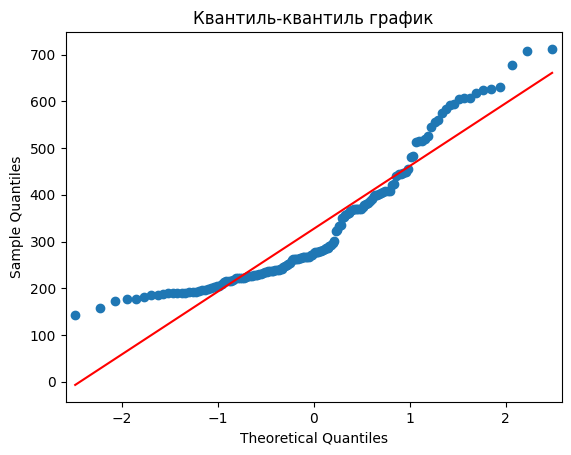

In [130]:
# Посмотрим характер распределения
sm.qqplot(data["receipts_count"], line='s')
plt.title('Квантиль-квантиль график')
plt.show()

> Можно выделить на графике несколько моменов, распределение далеко от нормального (что еще проверим тестом), выделяюься точки в хвостах, значение которых сильно отстают от основного распределения, как бы лежа в ли от линии укладки распределения на уровнях выше ~620 и ниже ~150, что в прочем может не являться выбросами (посмотри еще на боксплоте).

In [131]:
# Проведем тест Шапиро-Уилка
_, p = stats.shapiro(data["receipts_count"])
alpha = 0.05

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


> Собственно данные распределения не нормалино, метод z-отклоненей может дать неверные результаты. Посмотрим на диаграмму боксплот, прикинем интервал отсечения и отметим точки попавшие в него.

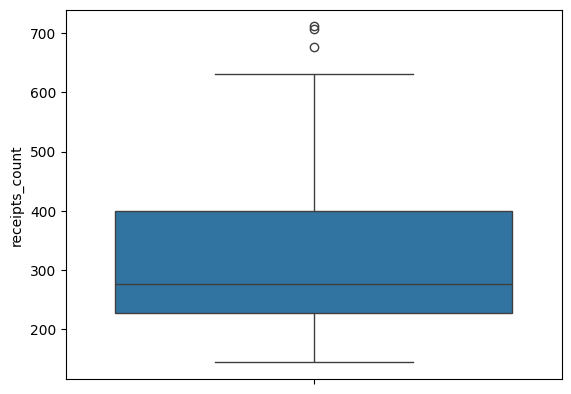

In [132]:
sns.boxplot(data["receipts_count"])
plt.show()

In [133]:
data["stats_flag"] = data["receipts_count"].apply(lambda x: 1 if x >= 635 else 0)

# Посмотрим на полученные точки
display(data[data["stats_flag"] == 1])

,brand_id,date,receipts_count,programm_factor,stats_flag
367,178,2016-10-31,677,False,1
394,178,2016-11-09,708,False,1
397,178,2016-11-10,712,False,1


In [134]:
low_bnd_st = data["date"][data["stats_flag"] == 1].dt.date.min()
up_bnd_st = (data["date"][data["stats_flag"] == 1].dt.date.max())

print(low_bnd_st)
print(up_bnd_st)


2016-10-31
2016-11-10


> Отметим, что точки распределены плотно в почти непрерывном интервале, что дает нам повод отметить весь интервал как аномальный, принимая за его границы первую и последнюю даты

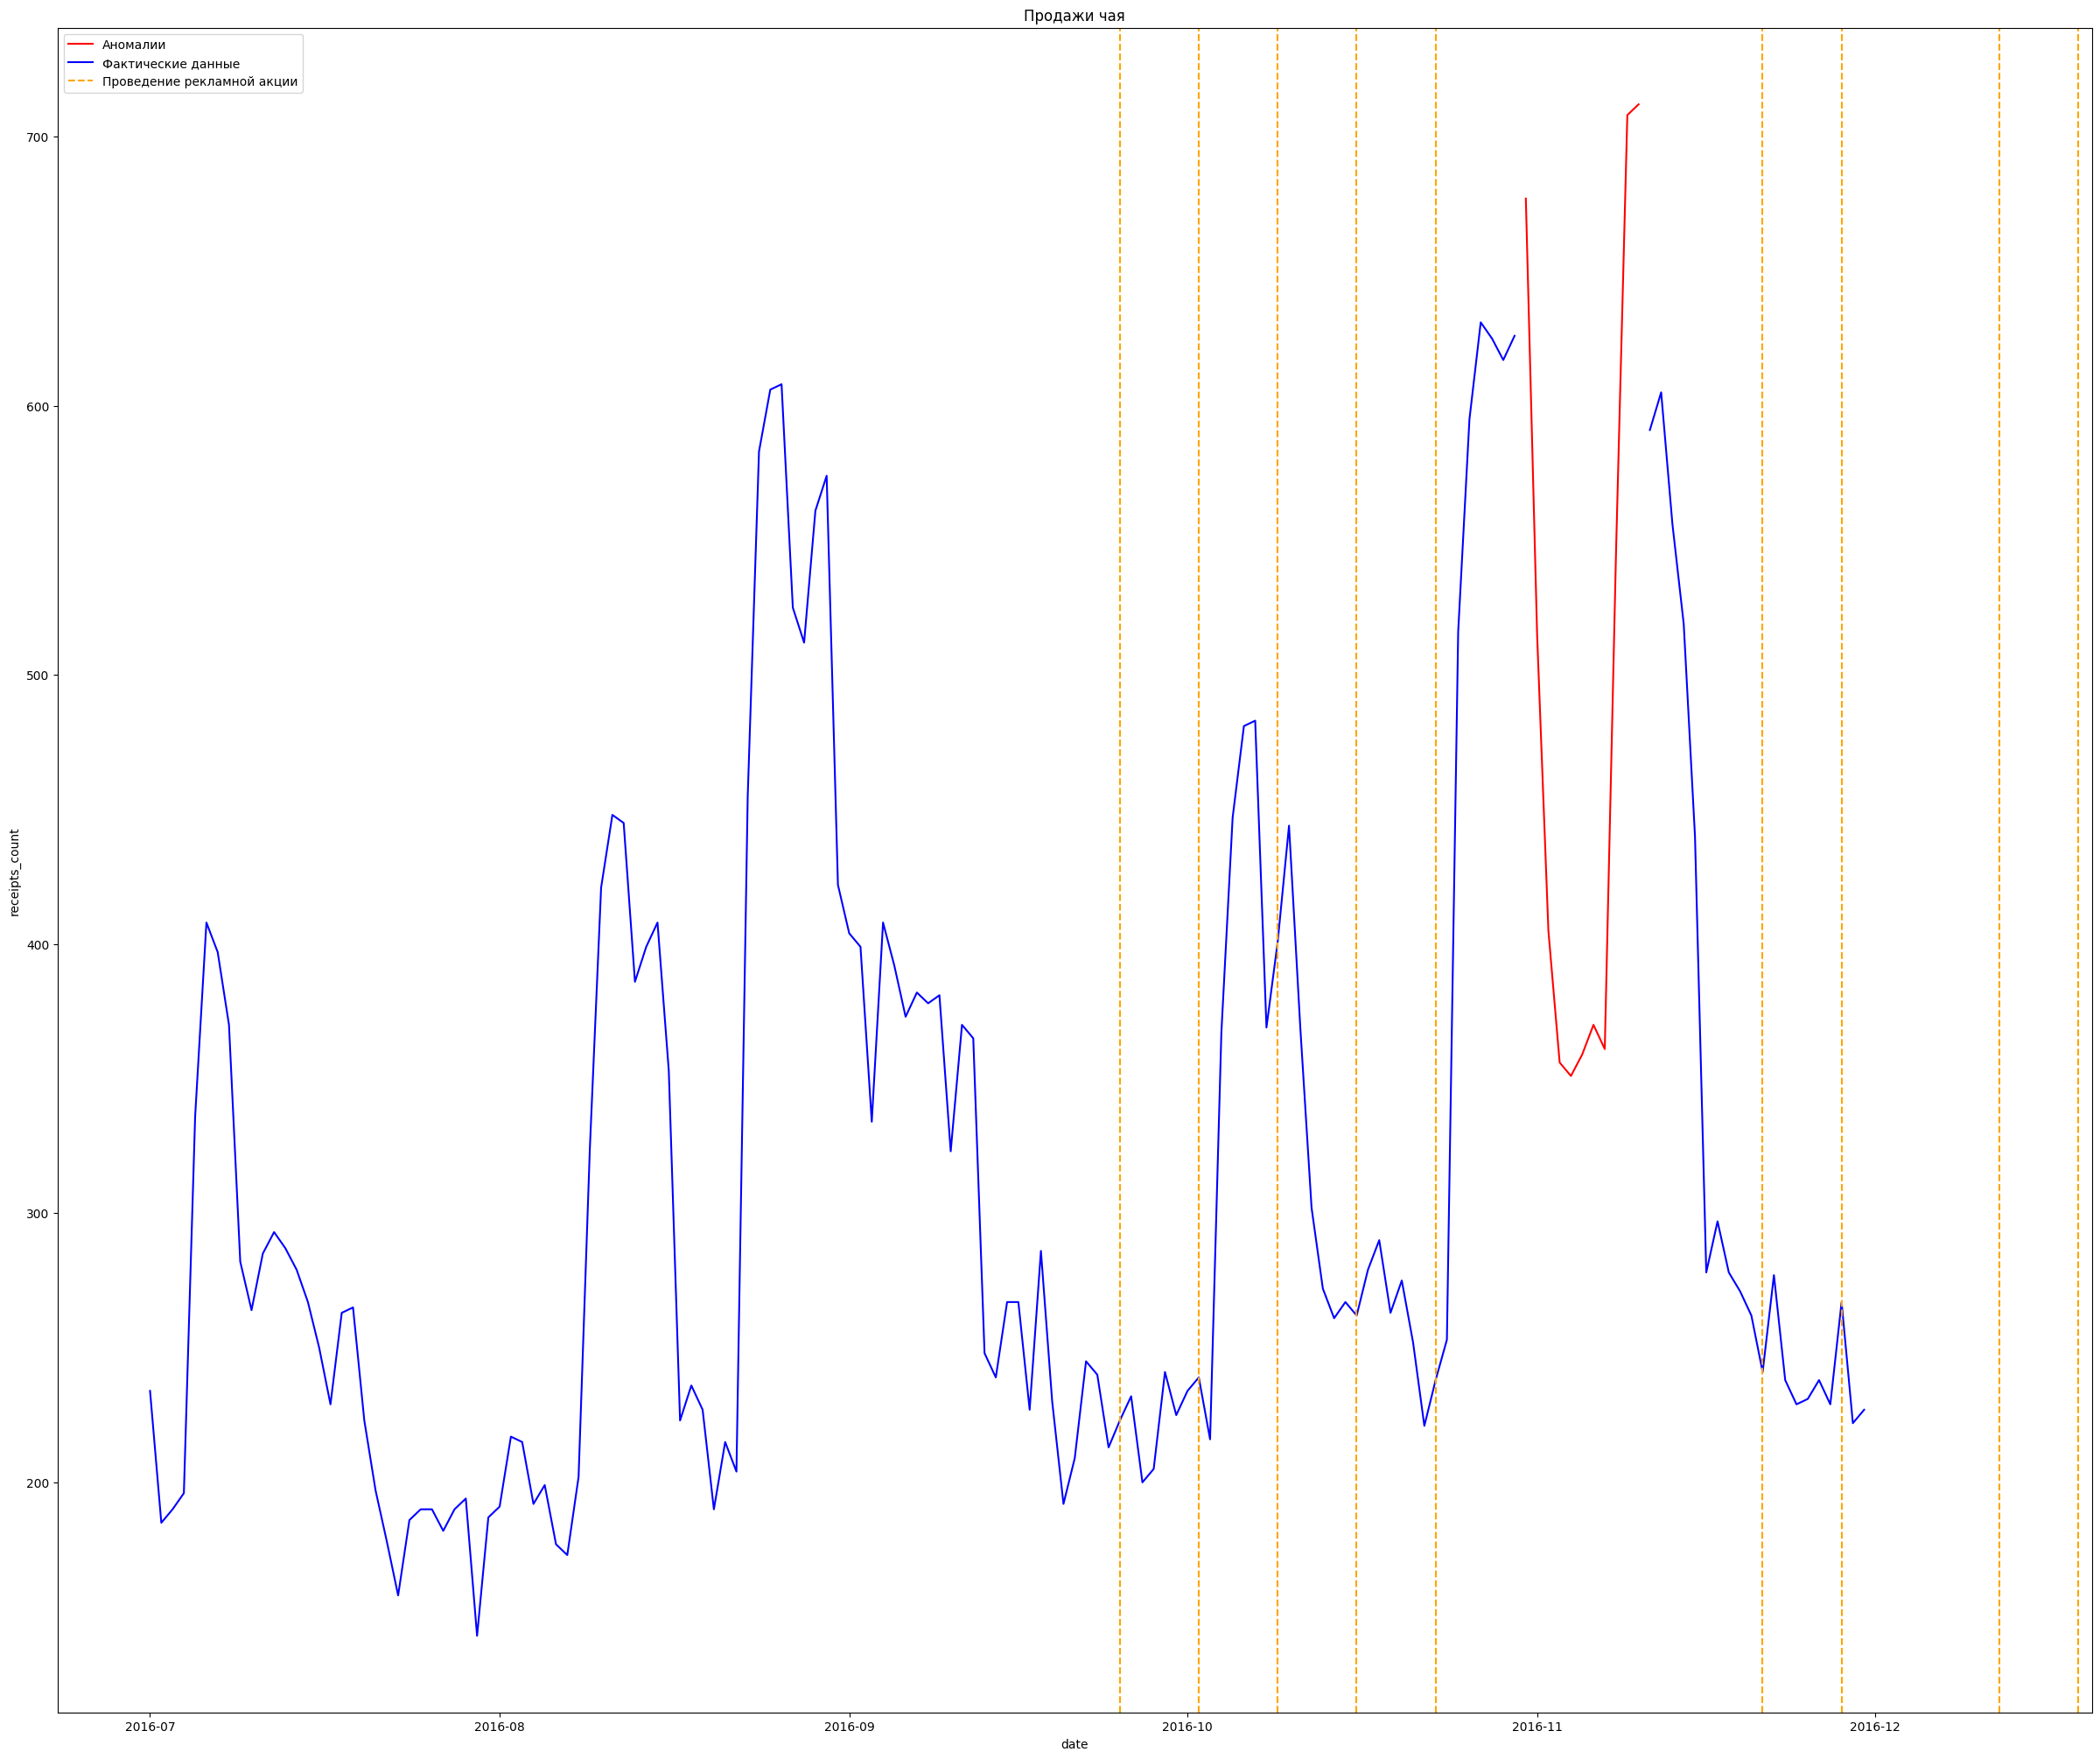

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

# Наивно выделим интервал отсекаемый аномалиями
sns.lineplot(
    x=data["date"][
        (data["date"].dt.date >= low_bnd_st) & (data["date"].dt.date <= up_bnd_st)
    ],
    y=data["receipts_count"][
        (data["date"].dt.date >= low_bnd_st) & (data["date"].dt.date <= up_bnd_st)
    ],
    ax=axes,
    c="red",
    label= "Аномалии"
)

# Фактические данные
sns.lineplot(
    x=data["date"][(data["date"].dt.date < low_bnd_st)],
    y=data["receipts_count"][(data["date"].dt.date < low_bnd_st)],
    ax=axes,
    c="blue",
    label="Фактические данные"
)

sns.lineplot(
    x=data["date"][(data["date"].dt.date > up_bnd_st)],
    y=data["receipts_count"][(data["date"].dt.date > up_bnd_st)],
    ax=axes,
    c="blue",
)

# Построим линии пересечения на основе данных по показу Что, Где, Когда.
lines = []
for i in programs_date["date"]:
    line = axes.axvline(x=i, color="orange", linestyle="--")
    lines.append(line)

# Добавление легенды
handles, labels = axes.get_legend_handles_labels()
handles.extend(lines)
labels.extend(["Проведение рекламной акции"])
axes.legend(handles, labels, loc='best')

# Добавление названия к графику
axes.set_title("Продажи чая")

plt.show()

> Можно заметить потенциальную зону где лежат аномальные значения ряда, стоит отметить тот факт, что аномалии лежат после периода интенсивной интервенции, что согласуется с предположением о куммулятивном отложенном эффекте рекламной акции.

> Нужно провести дополнительный анализ и в случае выделения данного интервала, как аномального мы сможем прийти к выводу является ли это:
> 1. Слабостью подходов (данный вывод будет возможен в случае несогласованности моделей и подходов по выделению аномальных значений).
> 2. Влиянием экзогеного фактора не связанного с внедрением интеграции (данное предположение будет верно в случае совпадения аномалных зон на графиках конкурентов, не проводивших рекламную акцию используя тот же канал распостранения информации, т.е. Что, Где, Когда)
> 3. Положительным влиянием интеграции на рост таргета.

---
### Посмотрим как дела у конкурентов.

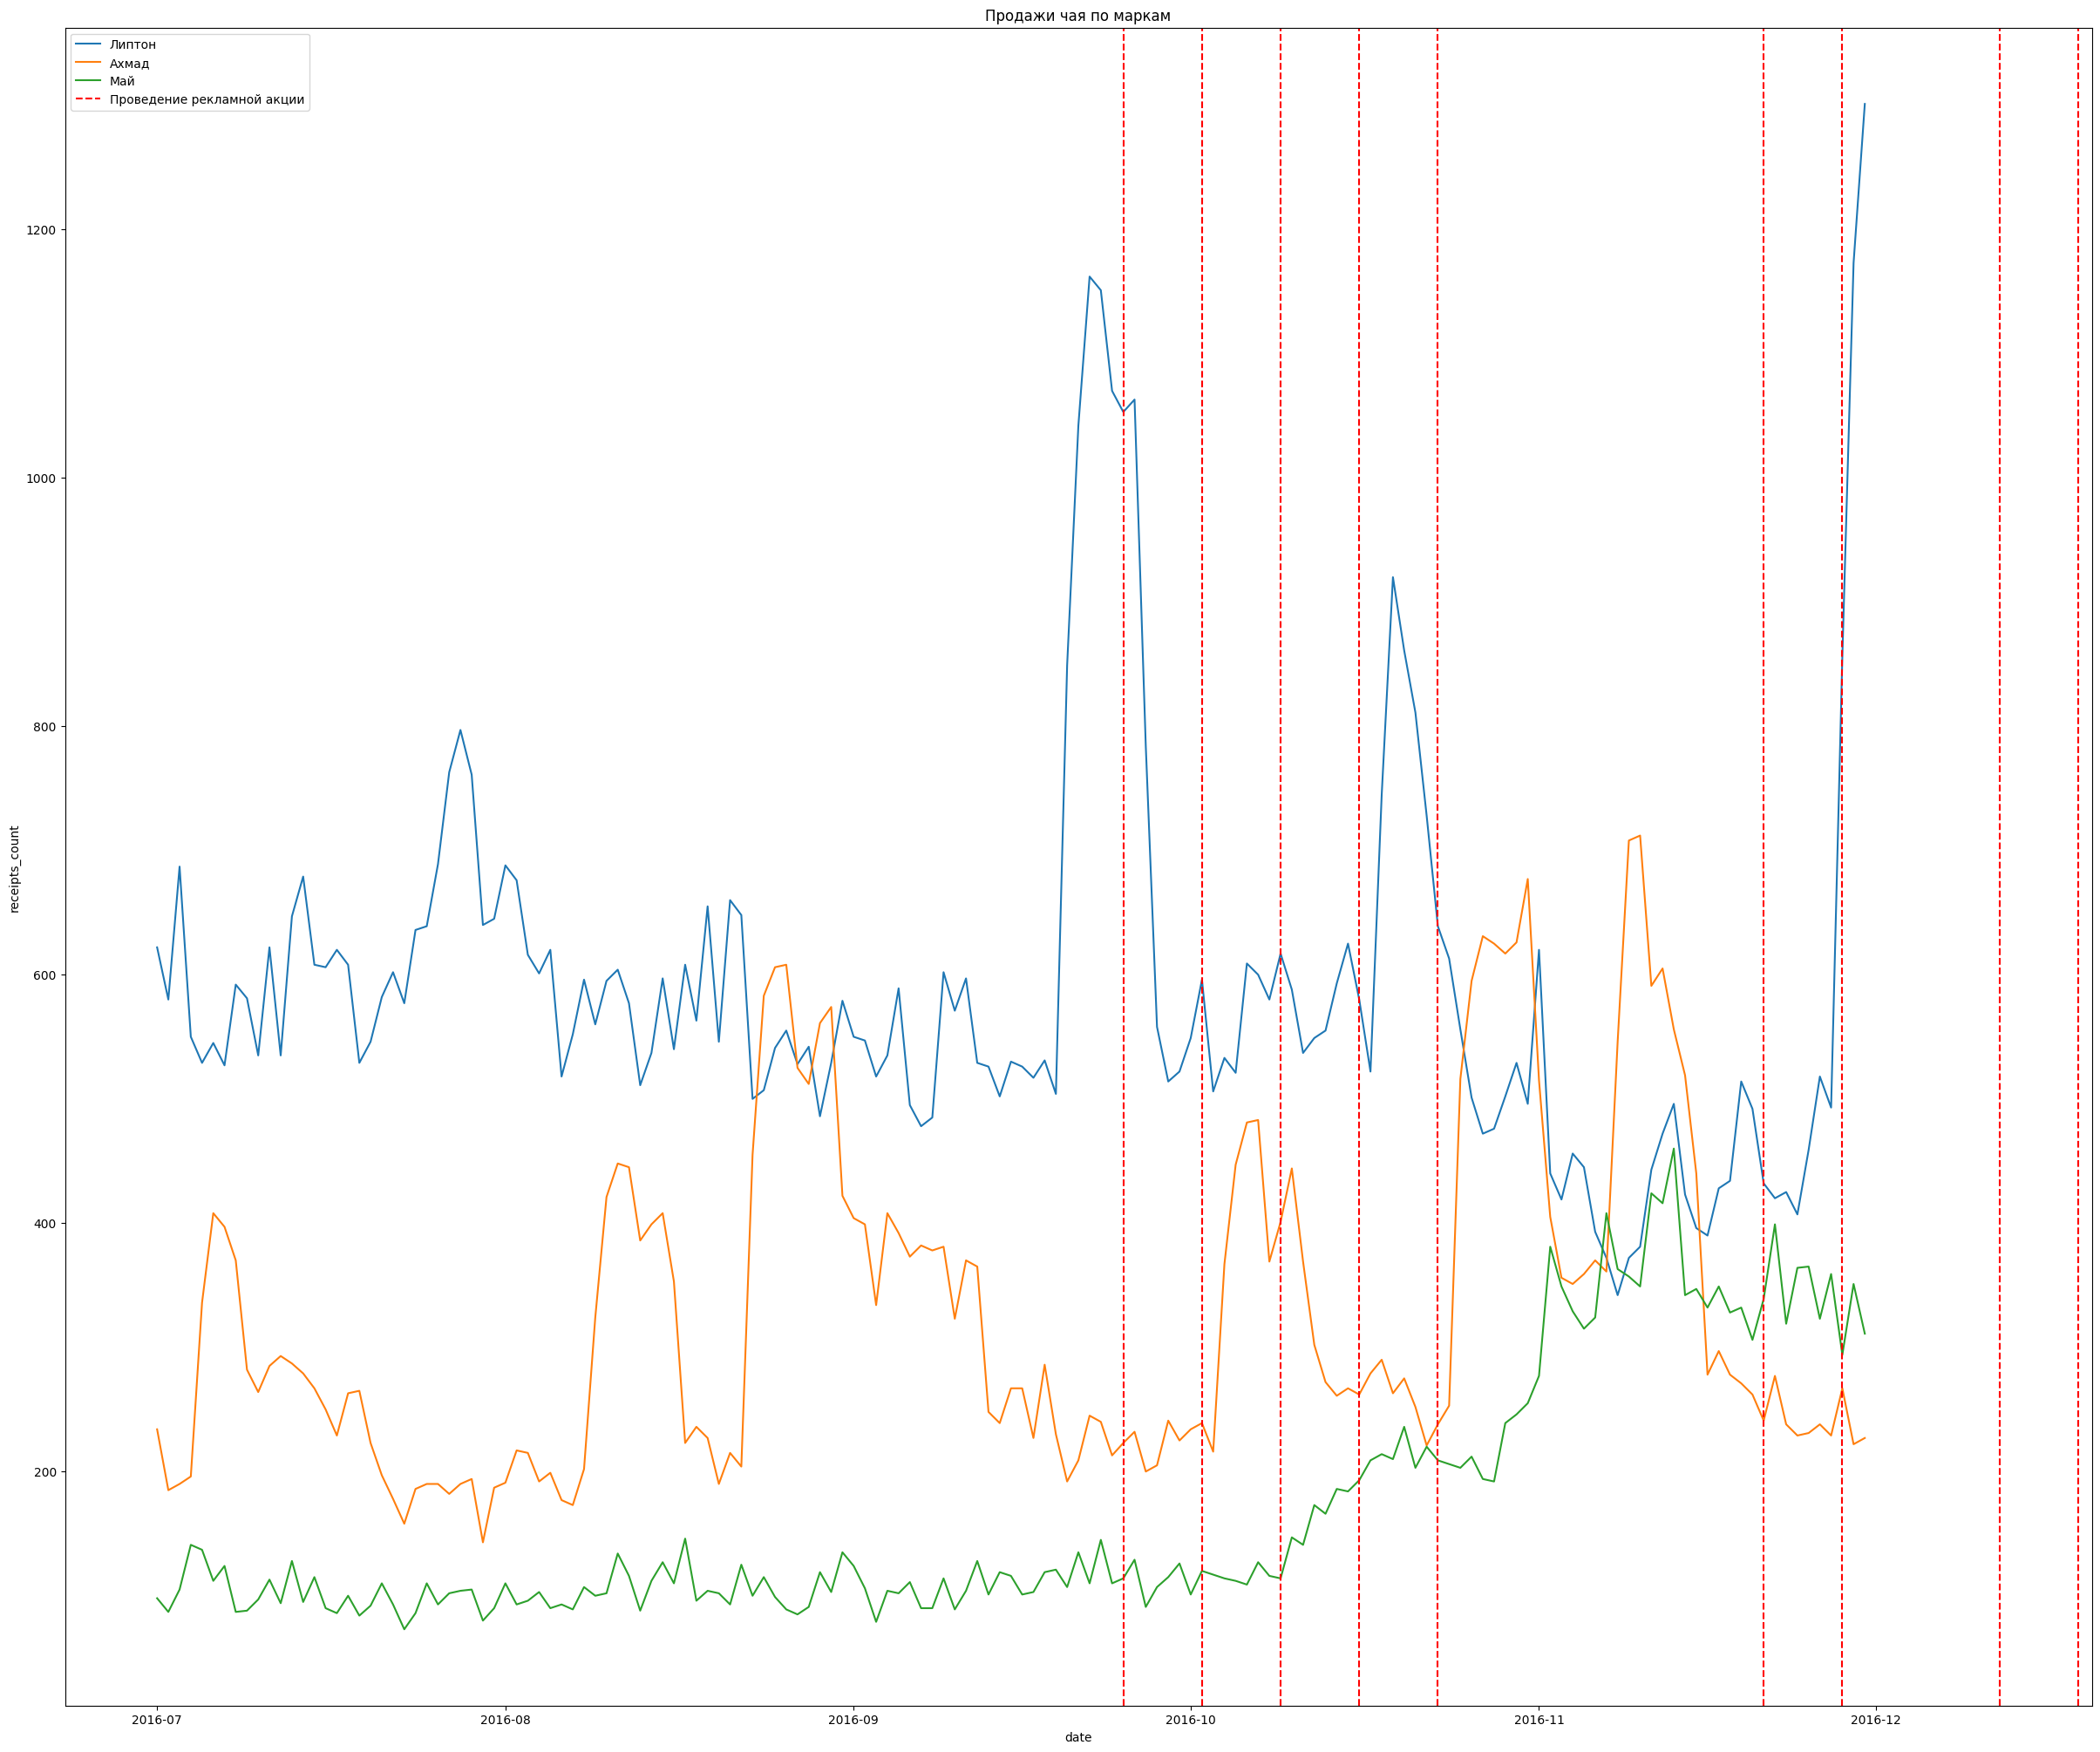

In [136]:
lipton = data_raw.query("brand_id == 29")
ahmad = data_raw.query("brand_id == 178")
may = data_raw.query("brand_id == 5152")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

sns.lineplot(
    x=lipton["date"],
    y=lipton["receipts_count"],
    ax=axes,
    label="Липтон"
)

sns.lineplot(
    x=ahmad["date"],
    y=ahmad["receipts_count"],
    ax=axes,
    label="Ахмад"
)

sns.lineplot(
    x=may["date"],
    y=may["receipts_count"],
    ax=axes,
    label="Май"
)

# Построим линии пересечения на основе данных по показу Что, Где, Когда.
lines = []
for i in programs_date["date"]:
    line = axes.axvline(x=i, color="red", linestyle="--")
    lines.append(line)

# Добавление легенды
handles, labels = axes.get_legend_handles_labels()
handles.extend(lines)
labels.extend(["Проведение рекламной акции"])
axes.legend(handles, labels, loc='best')

# Добавление названия к графику
axes.set_title("Продажи чая по маркам")

plt.show()

> Можно отметить тот факт, что интересующая нас аномальная зона по характеру пиков не совпадает с конкурентами, т.е. рельеф всплесков продаж не когерентен в контексте временного интервала и вероятность влияния стороннего экзогенного фактора минимально. Исходя из этого мы можем смело приступить к анализу аномалий ML- методами.

---
### ML- подход

#### Начнем с временных рядов

In [137]:
# Тест на стационарность
def adfuller_test(data, column='None'):
    test = adfuller(data[column])
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])

    if (test[0] > test[4]["5%"]):
        print("ряд не стационарен")
    else:
        print("ряд стационарен")

In [138]:
# Немного срежем углы и определим что для дальнейших манипуляций d = 1
adfuller_test(data.diff().dropna(), "receipts_count")
d = 1

adf:  -6.874263180315063
p-value:  1.4884446590032763e-09
Critical values:  {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
ряд стационарен


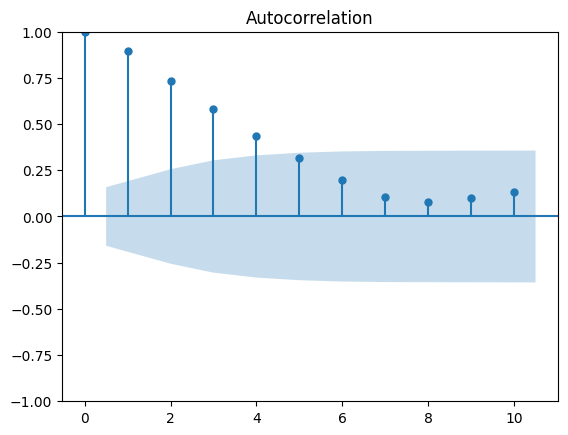

In [139]:
# Посмотрим на график автрокорреляции для выделение компоненты q.
# q = 5
sm.graphics.tsa.plot_acf(data["receipts_count"], lags=10)
q = 5
plt.show()

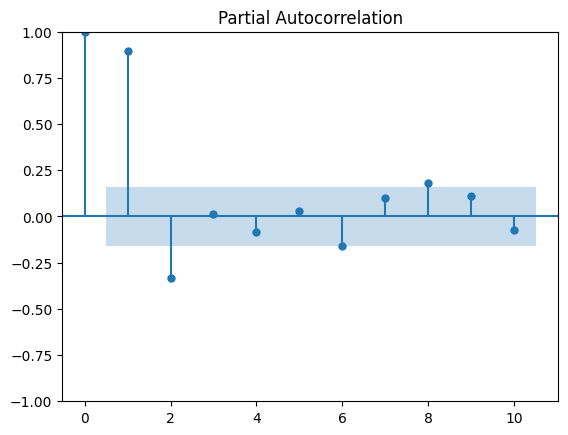

In [140]:
# Посмотрим на график частичной автрокорреляции для выделение компоненты p.
# p = 2
sm.graphics.tsa.plot_pacf(data["receipts_count"], lags=10)
p = 2
plt.show()

----
### Попробуем спрогнозировать моделью ARIMA 

In [141]:
# Выделим границы проведения акции-программы что бы в дальнейшем
# использовать для формирования трейн/теста
adv_prog_periods = data["date"][data["programm_factor"] == True]
split_list = [i for i in adv_prog_periods]

In [142]:
# Инициализация пустого датафрейма
prognosis_df = pd.DataFrame()

# Наполнение датафрейма прогнозными интервалами
for i in range(len(split_list)):
    try:
        train = data[data["date"] < split_list[i]]
        test = data[(data["date"] >= split_list[i]) & (data["date"] < split_list[i+1])]

        y_train = train.set_index("date")["receipts_count"]
        y_test = test.set_index("date")["receipts_count"]
        
        model = ARIMA(y_train.values.reshape(-1), order=(p,d,q))
        
        arima_predictions = model.fit().predict(
            start=len(y_train),
            end=len(y_train)+len(y_test) -1,  
            dynamic=False)
        
        result = pd.DataFrame(arima_predictions, index=y_test.index, columns=["arima_predictions"])
        
        prognosis_df = pd.concat([prognosis_df, result], axis=0)
    except IndexError:
        pass

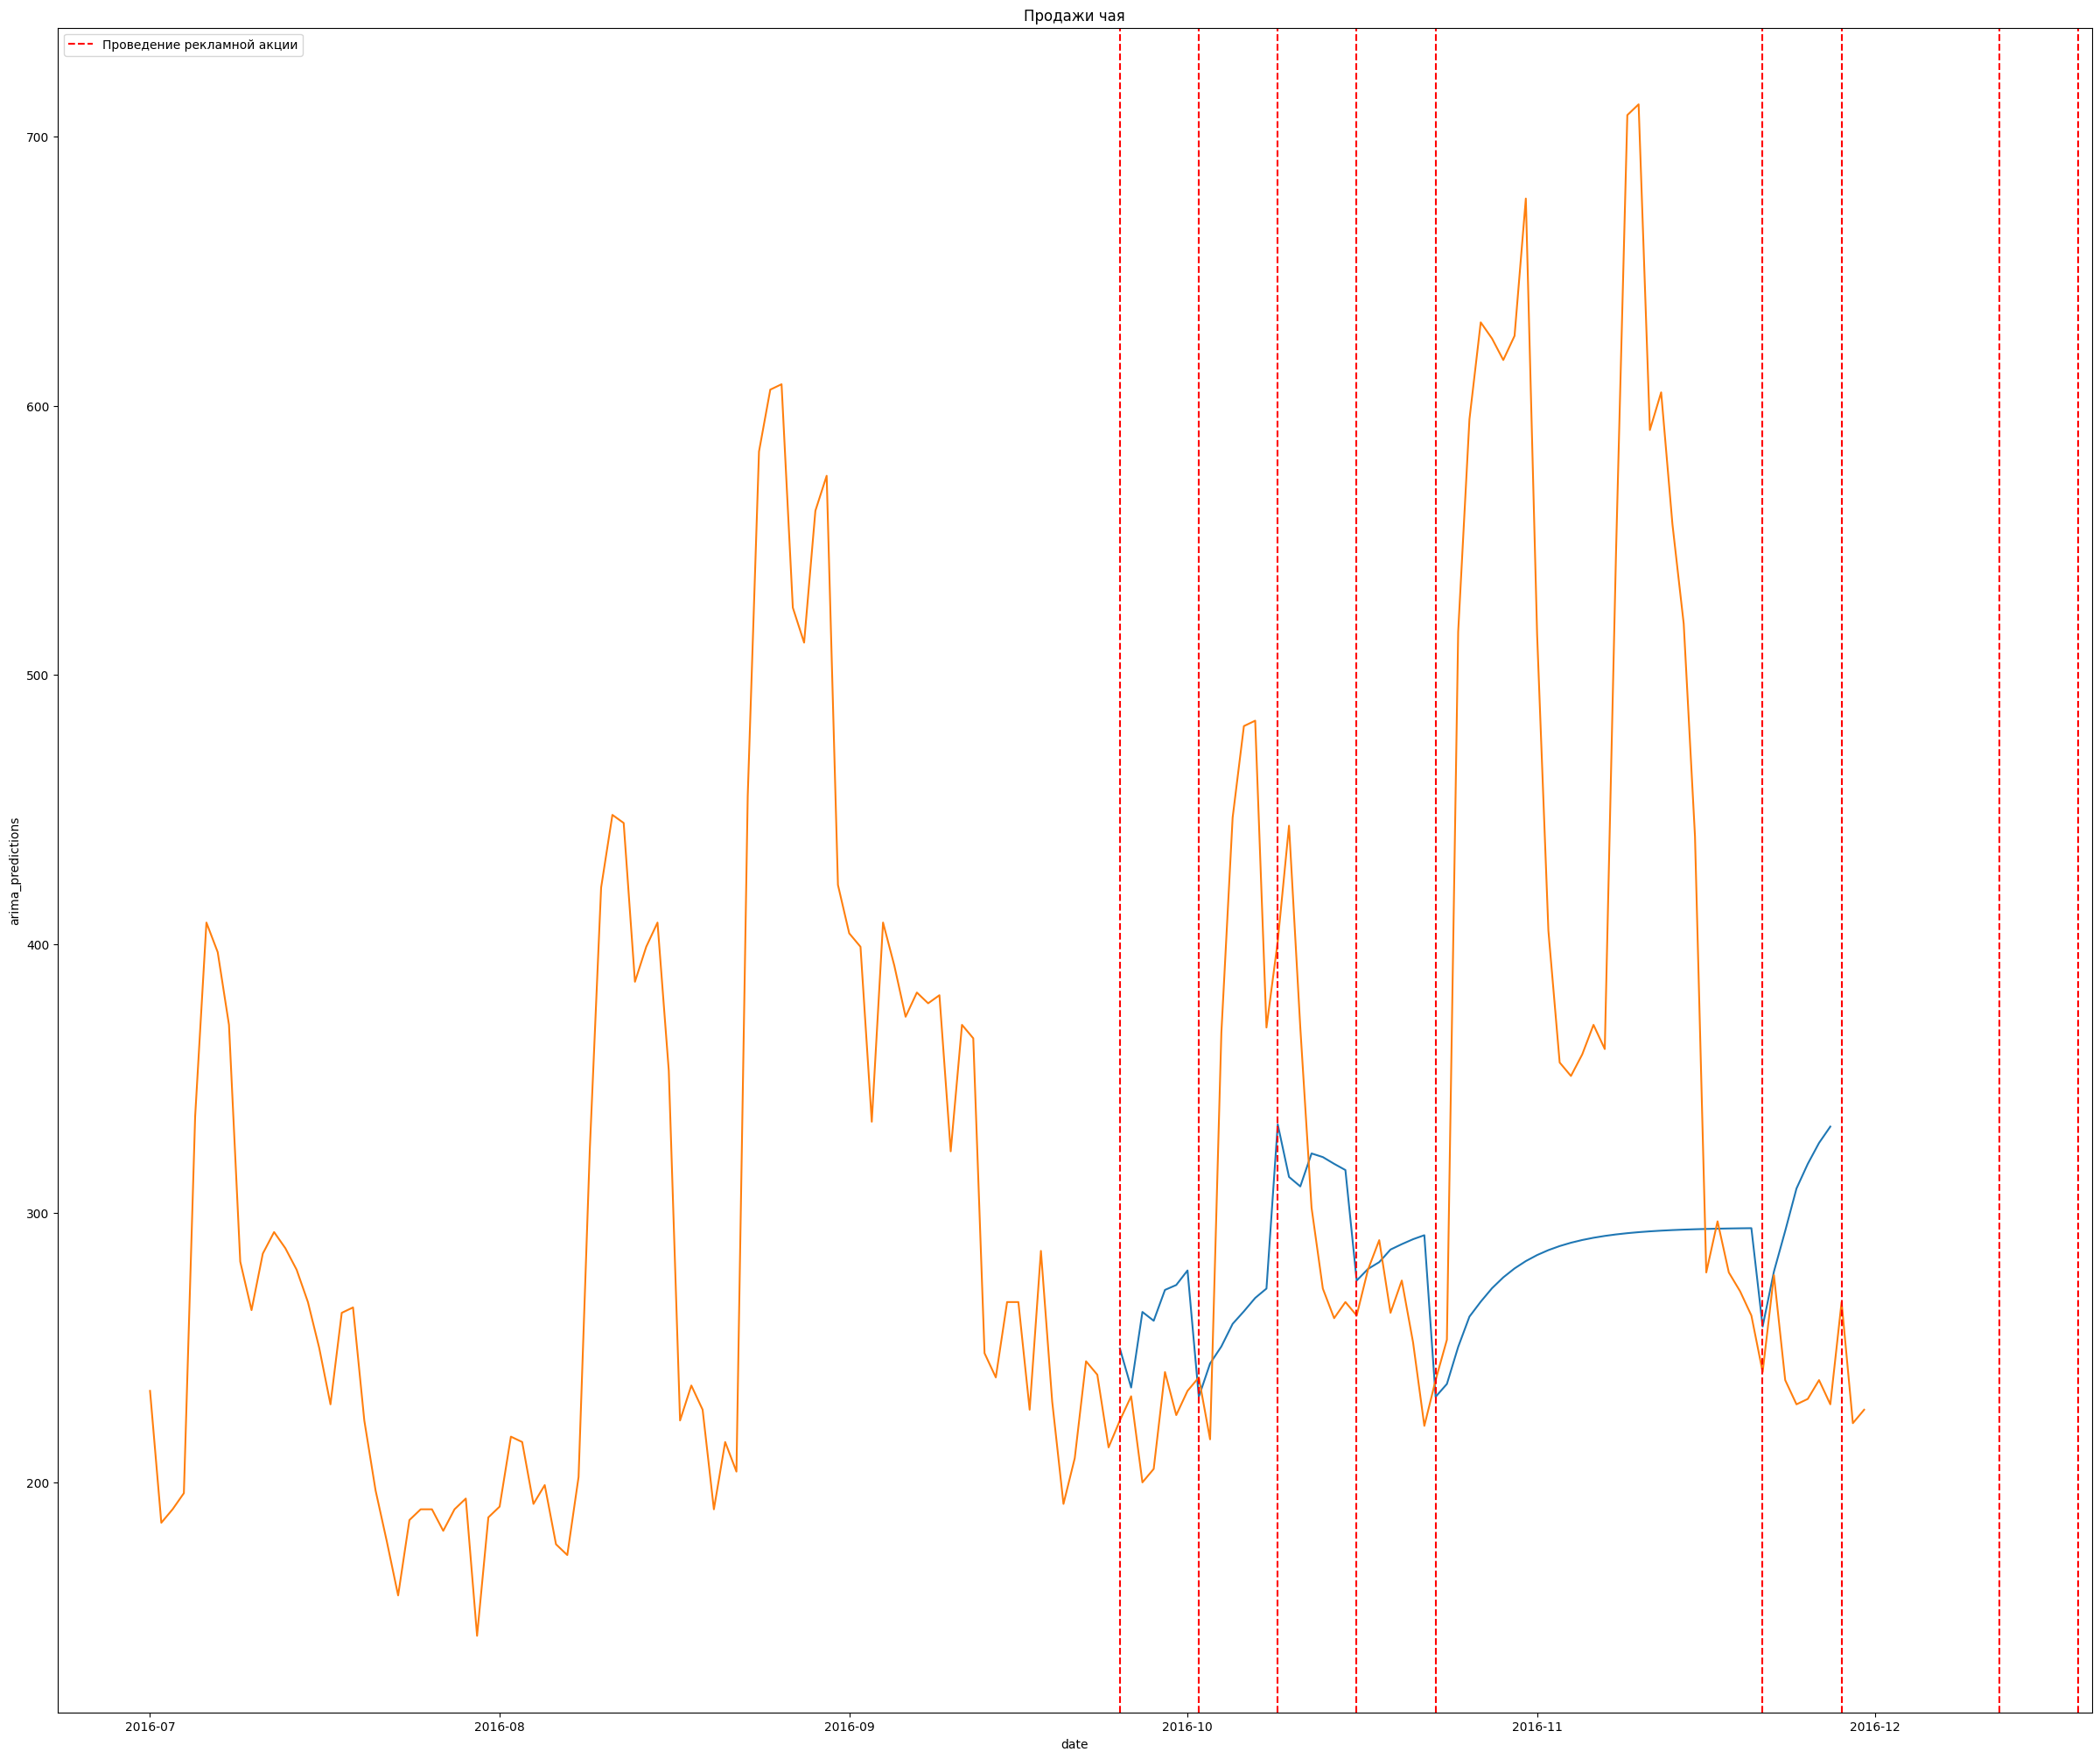

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

sns.lineplot(data=prognosis_df, x="date", y="arima_predictions", ax=axes)
sns.lineplot(x=data["date"], y=data["receipts_count"], ax=axes)

# Построим линии пересечения на основе данных по показу Что, Где, Когда.
lines = []
for i in programs_date["date"]:
    line = axes.axvline(x=i, color="red", linestyle="--")
    lines.append(line)

# Добавление легенды
handles, labels = axes.get_legend_handles_labels()
handles.extend(lines)
labels.extend(["Проведение рекламной акции"])
axes.legend(handles, labels, loc='best')

# Добавление названия к графику
axes.set_title("Продажи чая")

plt.show()

> Можно отметить интересный факт смещения прогноза и фактических значений- превосходство фактичесхих пиков значительно превосходит прогнозные пики, что может говорить о двух возможных сценариях, либо у нас слабая модель, либо сильное влияние экзогенного фактора (в нашем случае интеграции) не учтенных в модели.

---
### Попробуем спрогнозировать линейной регрессией (есть подозрения, что данных будет не достаточно для корретного прогнозирования линейкой)

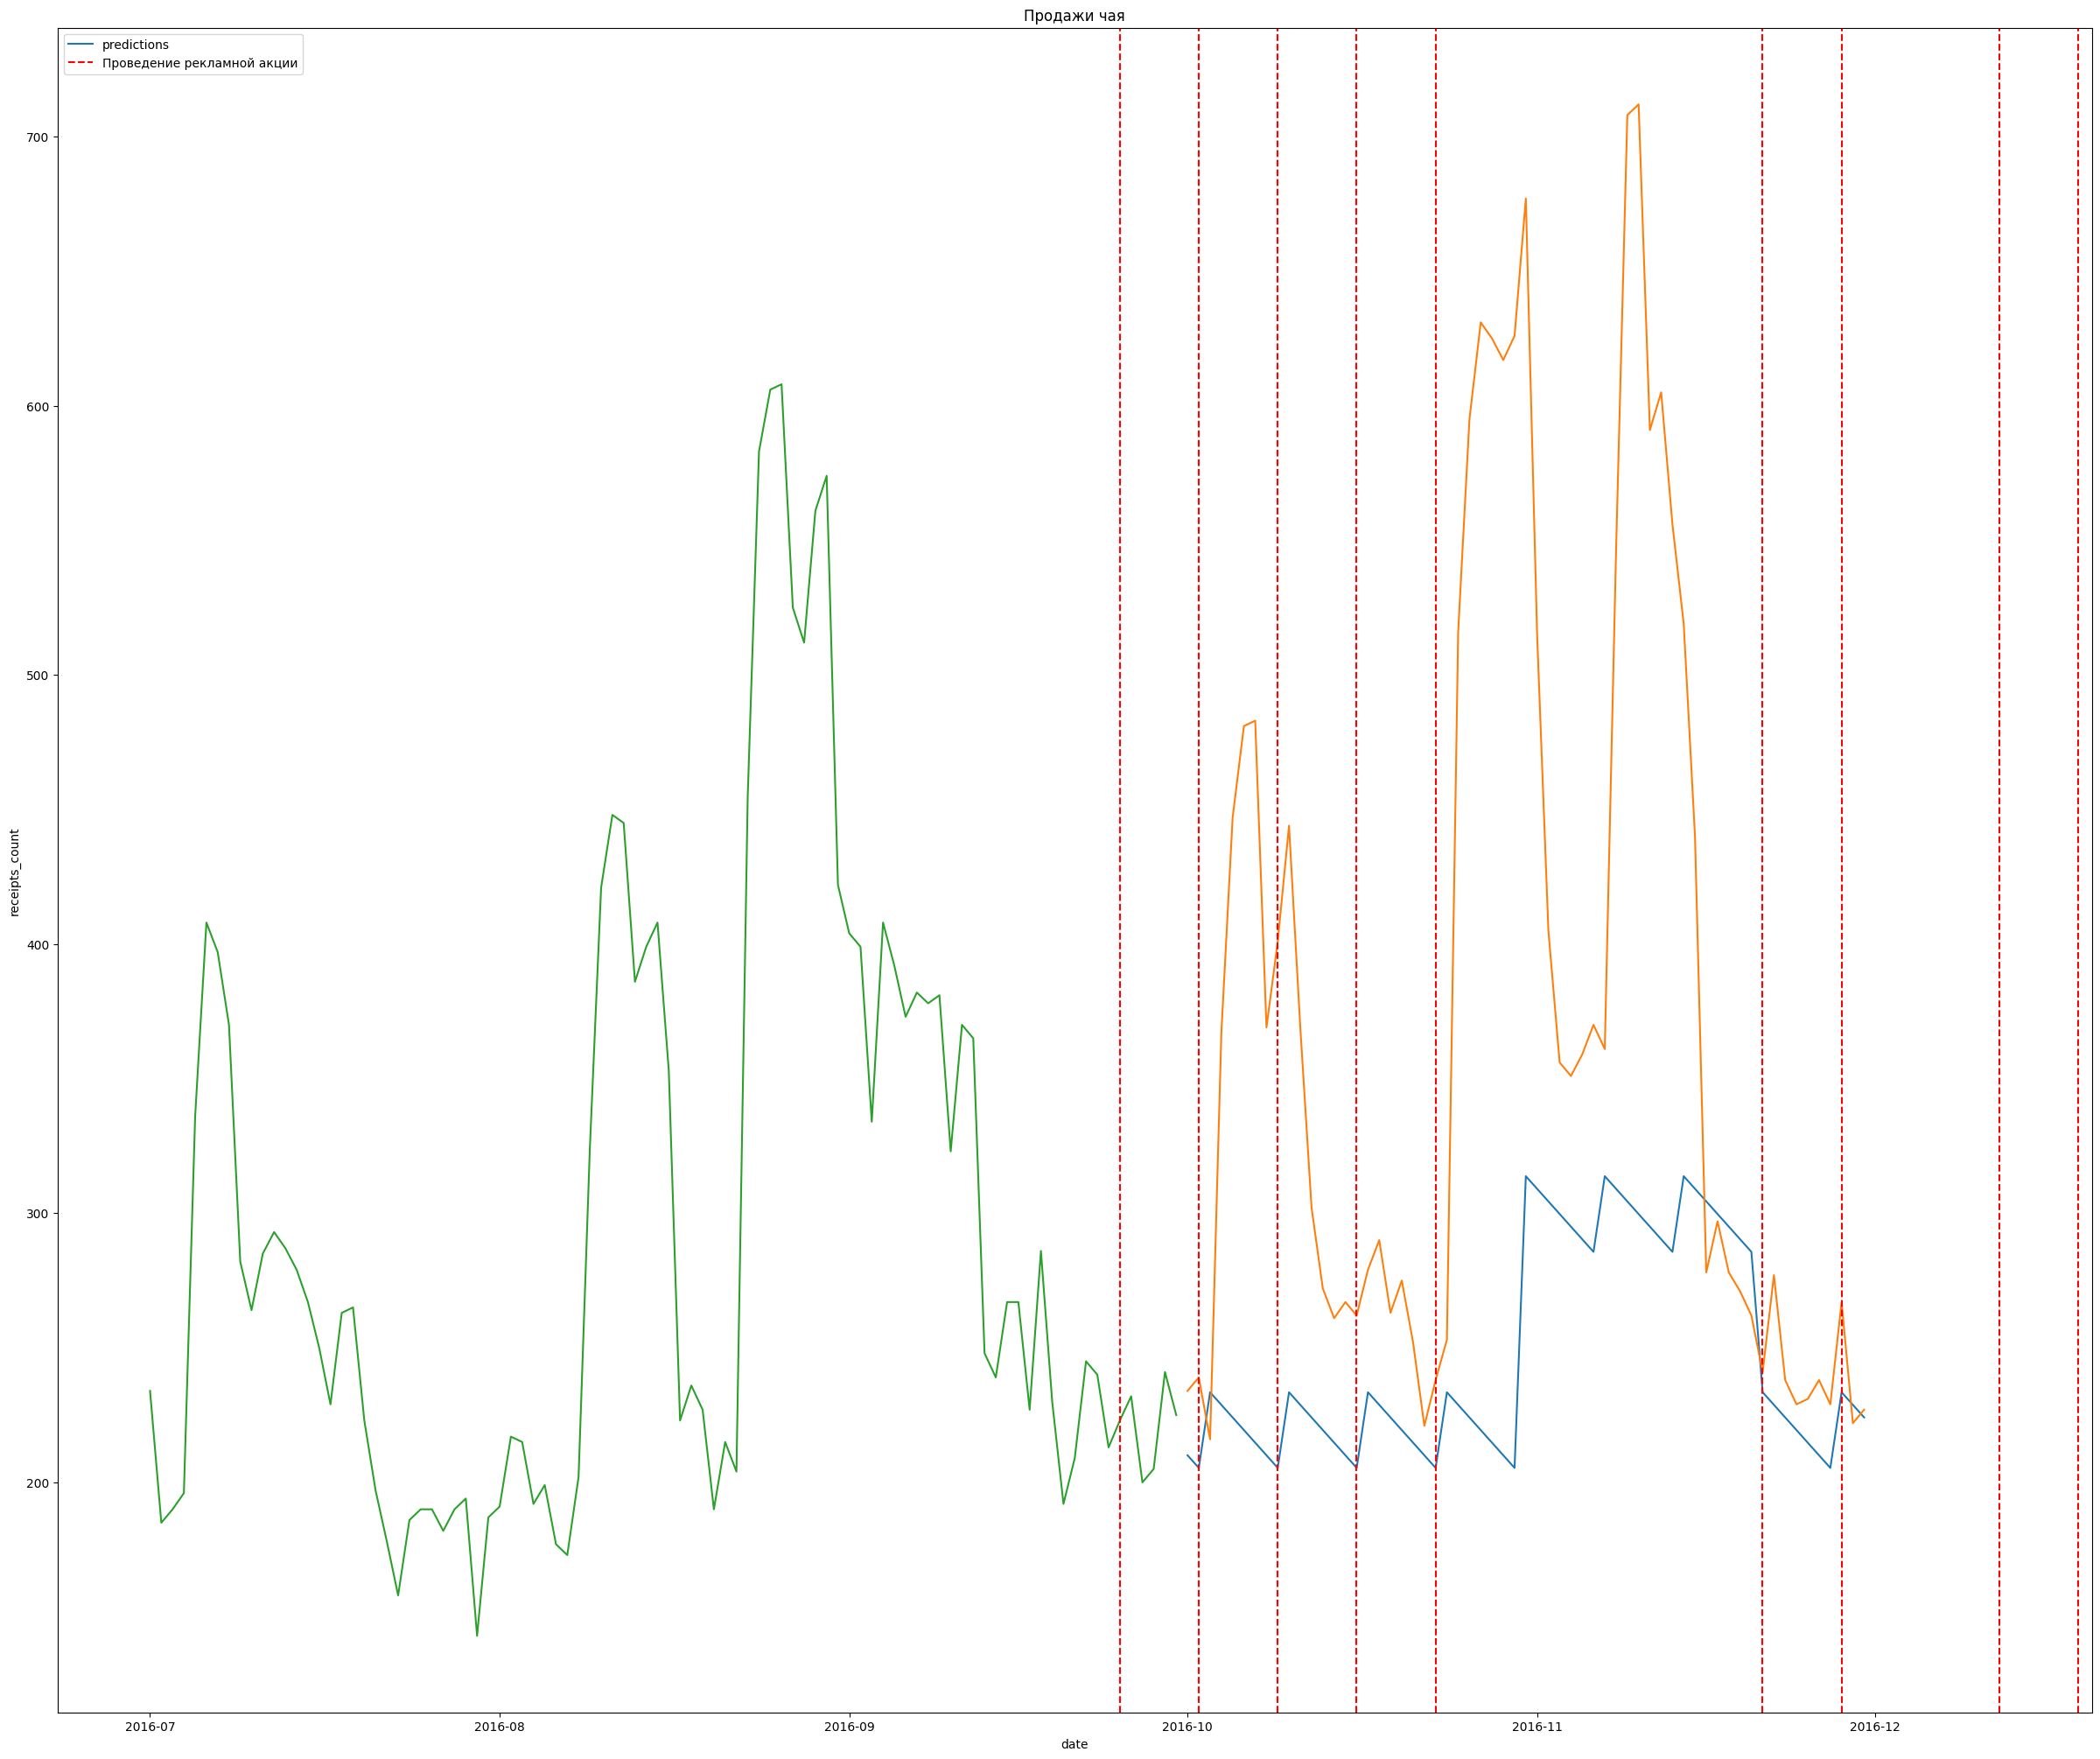

In [144]:
# Для начала рекодируем фактор интеграции, при чем по хитрому, ибо будем интерполировать на 7 дней.
linear_data = data.copy()

linear_data["programm_factor"].replace({True: 1, False: np.nan}, inplace=True)

# Собственно интерполяция
linear_data["programm_factor"].interpolate(method="linear", limit=7, inplace=True)

# Заполнение пропусков
linear_data["programm_factor"].fillna(0, inplace=True)

# Сформируем фичи от даты
linear_data["day_of_week"] = linear_data["date"].dt.dayofweek

linear_data["quarter"] = linear_data["date"].dt.quarter


# Пробуем спрогнозировать линейной регрессией 
test = linear_data[linear_data["date"].dt.month > 9].set_index("date")
train = linear_data[linear_data["date"].dt.month <= 9].set_index("date")

# Сформируем трейн/тест
test = test[
    ["programm_factor", "day_of_week", "quarter", "receipts_count"]
]

train = train[
    ["programm_factor", "day_of_week", "quarter", "receipts_count"]
]

X_train = train.drop(["receipts_count"], axis=1)
y_train = train["receipts_count"]

X_test = test.drop(["receipts_count"], axis=1)
y_test = test["receipts_count"]

# Начинаем моделировать
model = LinearRegression()

model.fit(X_train, y_train)

prediction = model.predict(X_test)

prediction = pd.DataFrame(prediction, index=y_test.index, columns=["predictions"])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

sns.lineplot(prediction, ax=axes,) 
sns.lineplot(y_test, ax=axes,)
sns.lineplot(y_train, ax=axes,)

# Построим линии пересечения на основе данных по показу Что, Где, Когда.
lines = []
for i in programs_date["date"]:
    line = axes.axvline(x=i, color="red", linestyle="--")
    lines.append(line)

# Добавление легенды
handles, labels = axes.get_legend_handles_labels()
handles.extend(lines)
labels.extend(["Проведение рекламной акции"])
axes.legend(handles, labels, loc='best')

# Добавление названия к графику
axes.set_title("Продажи чая")


plt.show()


> Модель линейной регрессии смогла смоделировать самый высокий пик в разрезе временного интервала, т.е. она смогла предсказать изменение тренда в период ноября но сильно недооценила масштабы пика, собственно как и модель авторегрессии.

---
### Проведем анализ плотности кластера DBSCAN

In [145]:
# Найдем аномалии используя DBSCAN
dbscan = DBSCAN(eps=3)

In [146]:
# Вызовем фитпредикт на вытянутом в столбец векторе значений
data["prediction_dbscan"] = dbscan.fit_predict(data["receipts_count"].values.reshape(-1, 1))

In [147]:
# Обнаруженные аномалии
data[data["prediction_dbscan"] < 0]

,brand_id,date,receipts_count,programm_factor,stats_flag,prediction_dbscan
13,178,2016-07-05,336,False,0,-1
19,178,2016-07-07,397,False,0,-1
31,178,2016-07-11,285,False,0,-1
34,178,2016-07-12,293,False,0,-1
37,178,2016-07-13,287,False,0,-1
...,...,...,...,...,...,...
406,178,2016-11-13,556,False,0,-1
409,178,2016-11-14,519,False,0,-1
412,178,2016-11-15,440,False,0,-1
418,178,2016-11-17,297,False,0,-1


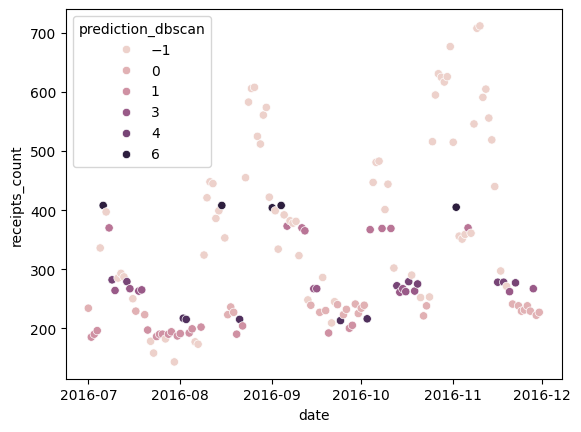

In [148]:
sns.scatterplot(data=data, y="receipts_count", x="date", hue="prediction_dbscan")
plt.show()

> Данные разряжены, и алгоритм закидывает в аномалии все флуктуации по продажам, что вряд ли корректно, попробуем агломеративную кластерицацию.

prediction_agglom
42     5
14     5
19     3
6      3
5      3
      ..
116    1
81     1
90     1
101    1
11     1
Name: count, Length: 122, dtype: int64

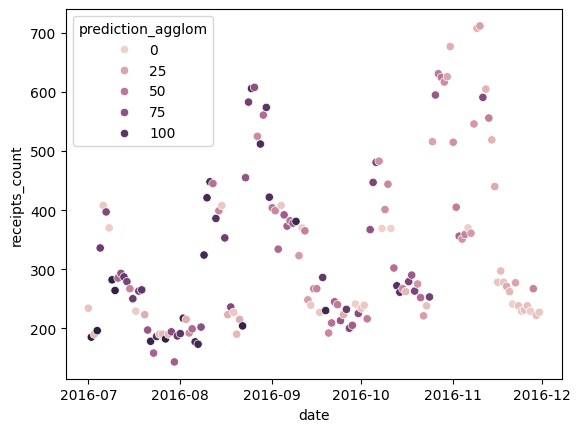

In [149]:
# Воспользуемся аггломеративной кластеризацией
agglom = AgglomerativeClustering(n_clusters=None, distance_threshold=1)

data["prediction_agglom"] = agglom.fit_predict(
    data["receipts_count"].values.reshape(-1, 1)
)

display(data["prediction_agglom"].value_counts())

sns.scatterplot(data=data, y="receipts_count", x="date", hue="prediction_agglom")
plt.show()

> Разряженность данных привела к переобучению аггломеративной кластеризации, выделив множество мелких кластеров.

----
### Попробуем снизать размерность данных для снижения разряженности, используя датасет с этапа линейной регрессии.

In [150]:
train

,programm_factor,day_of_week,quarter,receipts_count
date,,,,
2016-07-01,0.0,4,3,234
2016-07-02,0.0,5,3,185
2016-07-03,0.0,6,3,190
2016-07-04,0.0,0,3,196
2016-07-05,0.0,1,3,336
...,...,...,...,...
2016-09-26,1.0,0,3,232
2016-09-27,1.0,1,3,200
2016-09-28,1.0,2,3,205


In [151]:
test

,programm_factor,day_of_week,quarter,receipts_count
date,,,,
2016-10-01,1.0,5,4,234
2016-10-02,1.0,6,4,239
2016-10-03,1.0,0,4,216
2016-10-04,1.0,1,4,367
2016-10-05,1.0,2,4,447
...,...,...,...,...
2016-11-26,1.0,5,4,238
2016-11-27,1.0,6,4,229
2016-11-28,1.0,0,4,267


In [152]:
cluster_data = pd.concat([train, test], axis=0)
display(cluster_data.head(), cluster_data.tail())

,programm_factor,day_of_week,quarter,receipts_count
date,,,,
2016-07-01,0.0,4,3,234
2016-07-02,0.0,5,3,185
2016-07-03,0.0,6,3,190
2016-07-04,0.0,0,3,196
2016-07-05,0.0,1,3,336


,programm_factor,day_of_week,quarter,receipts_count
date,,,,
2016-11-26,1.0,5,4,238
2016-11-27,1.0,6,4,229
2016-11-28,1.0,0,4,267
2016-11-29,1.0,1,4,222
2016-11-30,1.0,2,4,227


In [153]:
# Нормализуем наши данные
starrd_scaler = StandardScaler().fit(cluster_data)
np_scaled = starrd_scaler.transform(cluster_data)
cluster_data = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
cluster_data = pca.fit_transform(cluster_data)

min_max_scaler = StandardScaler().fit(cluster_data)
np_scaled = min_max_scaler.transform(cluster_data)
cluster_data = pd.DataFrame(np_scaled)

cluster_data

,0,1
0,-0.941666,-0.539219
1,-1.043067,-1.092657
2,-1.055045,-1.373890
3,-0.923561,0.494976
4,-0.711982,0.894257
...,...,...
148,1.233267,-1.594502
149,1.198105,-1.946307
150,1.382581,0.083866
151,1.287804,-0.449409


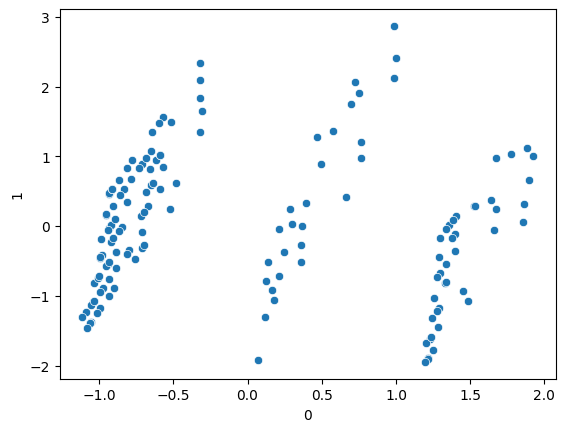

In [154]:
sns.scatterplot(data=cluster_data, x=0, y=1)
plt.show()

> С этим уже можно работать

prediction_dbscan
 0    85
 2    40
 1    15
 3    10
-1     3
Name: count, dtype: int64

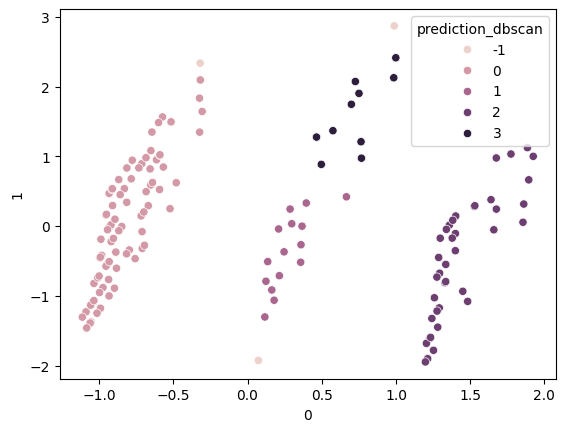

In [155]:
# Найдем аномалии используя DBSCAN
dbscan = DBSCAN(eps=0.5)

# Вызовем фитпредикт на вытянутом в столбец векторе значений
cluster_data["prediction_dbscan"] = dbscan.fit_predict(np.array(cluster_data))

display(cluster_data["prediction_dbscan"].value_counts())

sns.scatterplot(data=cluster_data, x=0, y=1, hue="prediction_dbscan")
plt.show()

> DBSCAN выделил 3 аномалии, проверим что за даты в них попали

In [156]:
# Добавим к основной таблице метки предсказаний кластера
data.reset_index(drop=True, inplace=True)
data["DBSCAN_on_PCA"] = cluster_data["prediction_dbscan"]
data

,brand_id,date,receipts_count,programm_factor,stats_flag,prediction_dbscan,prediction_agglom,DBSCAN_on_PCA
0,178,2016-07-01,234,False,0,0,8,0
1,178,2016-07-02,185,False,0,1,121,0
2,178,2016-07-03,190,False,0,1,14,0
3,178,2016-07-04,196,False,0,1,120,0
4,178,2016-07-05,336,False,0,-1,92,0
...,...,...,...,...,...,...,...,...
148,178,2016-11-26,238,False,0,0,9,2
149,178,2016-11-27,229,False,0,0,3,2
150,178,2016-11-28,267,True,0,3,42,2
151,178,2016-11-29,222,False,0,0,11,2


In [157]:
outliers = data[data["DBSCAN_on_PCA"] < 0]
outliers = outliers[["date", "receipts_count"]]
outliers

,date,receipts_count
59,2016-08-29,561
86,2016-09-25,223
122,2016-10-31,677


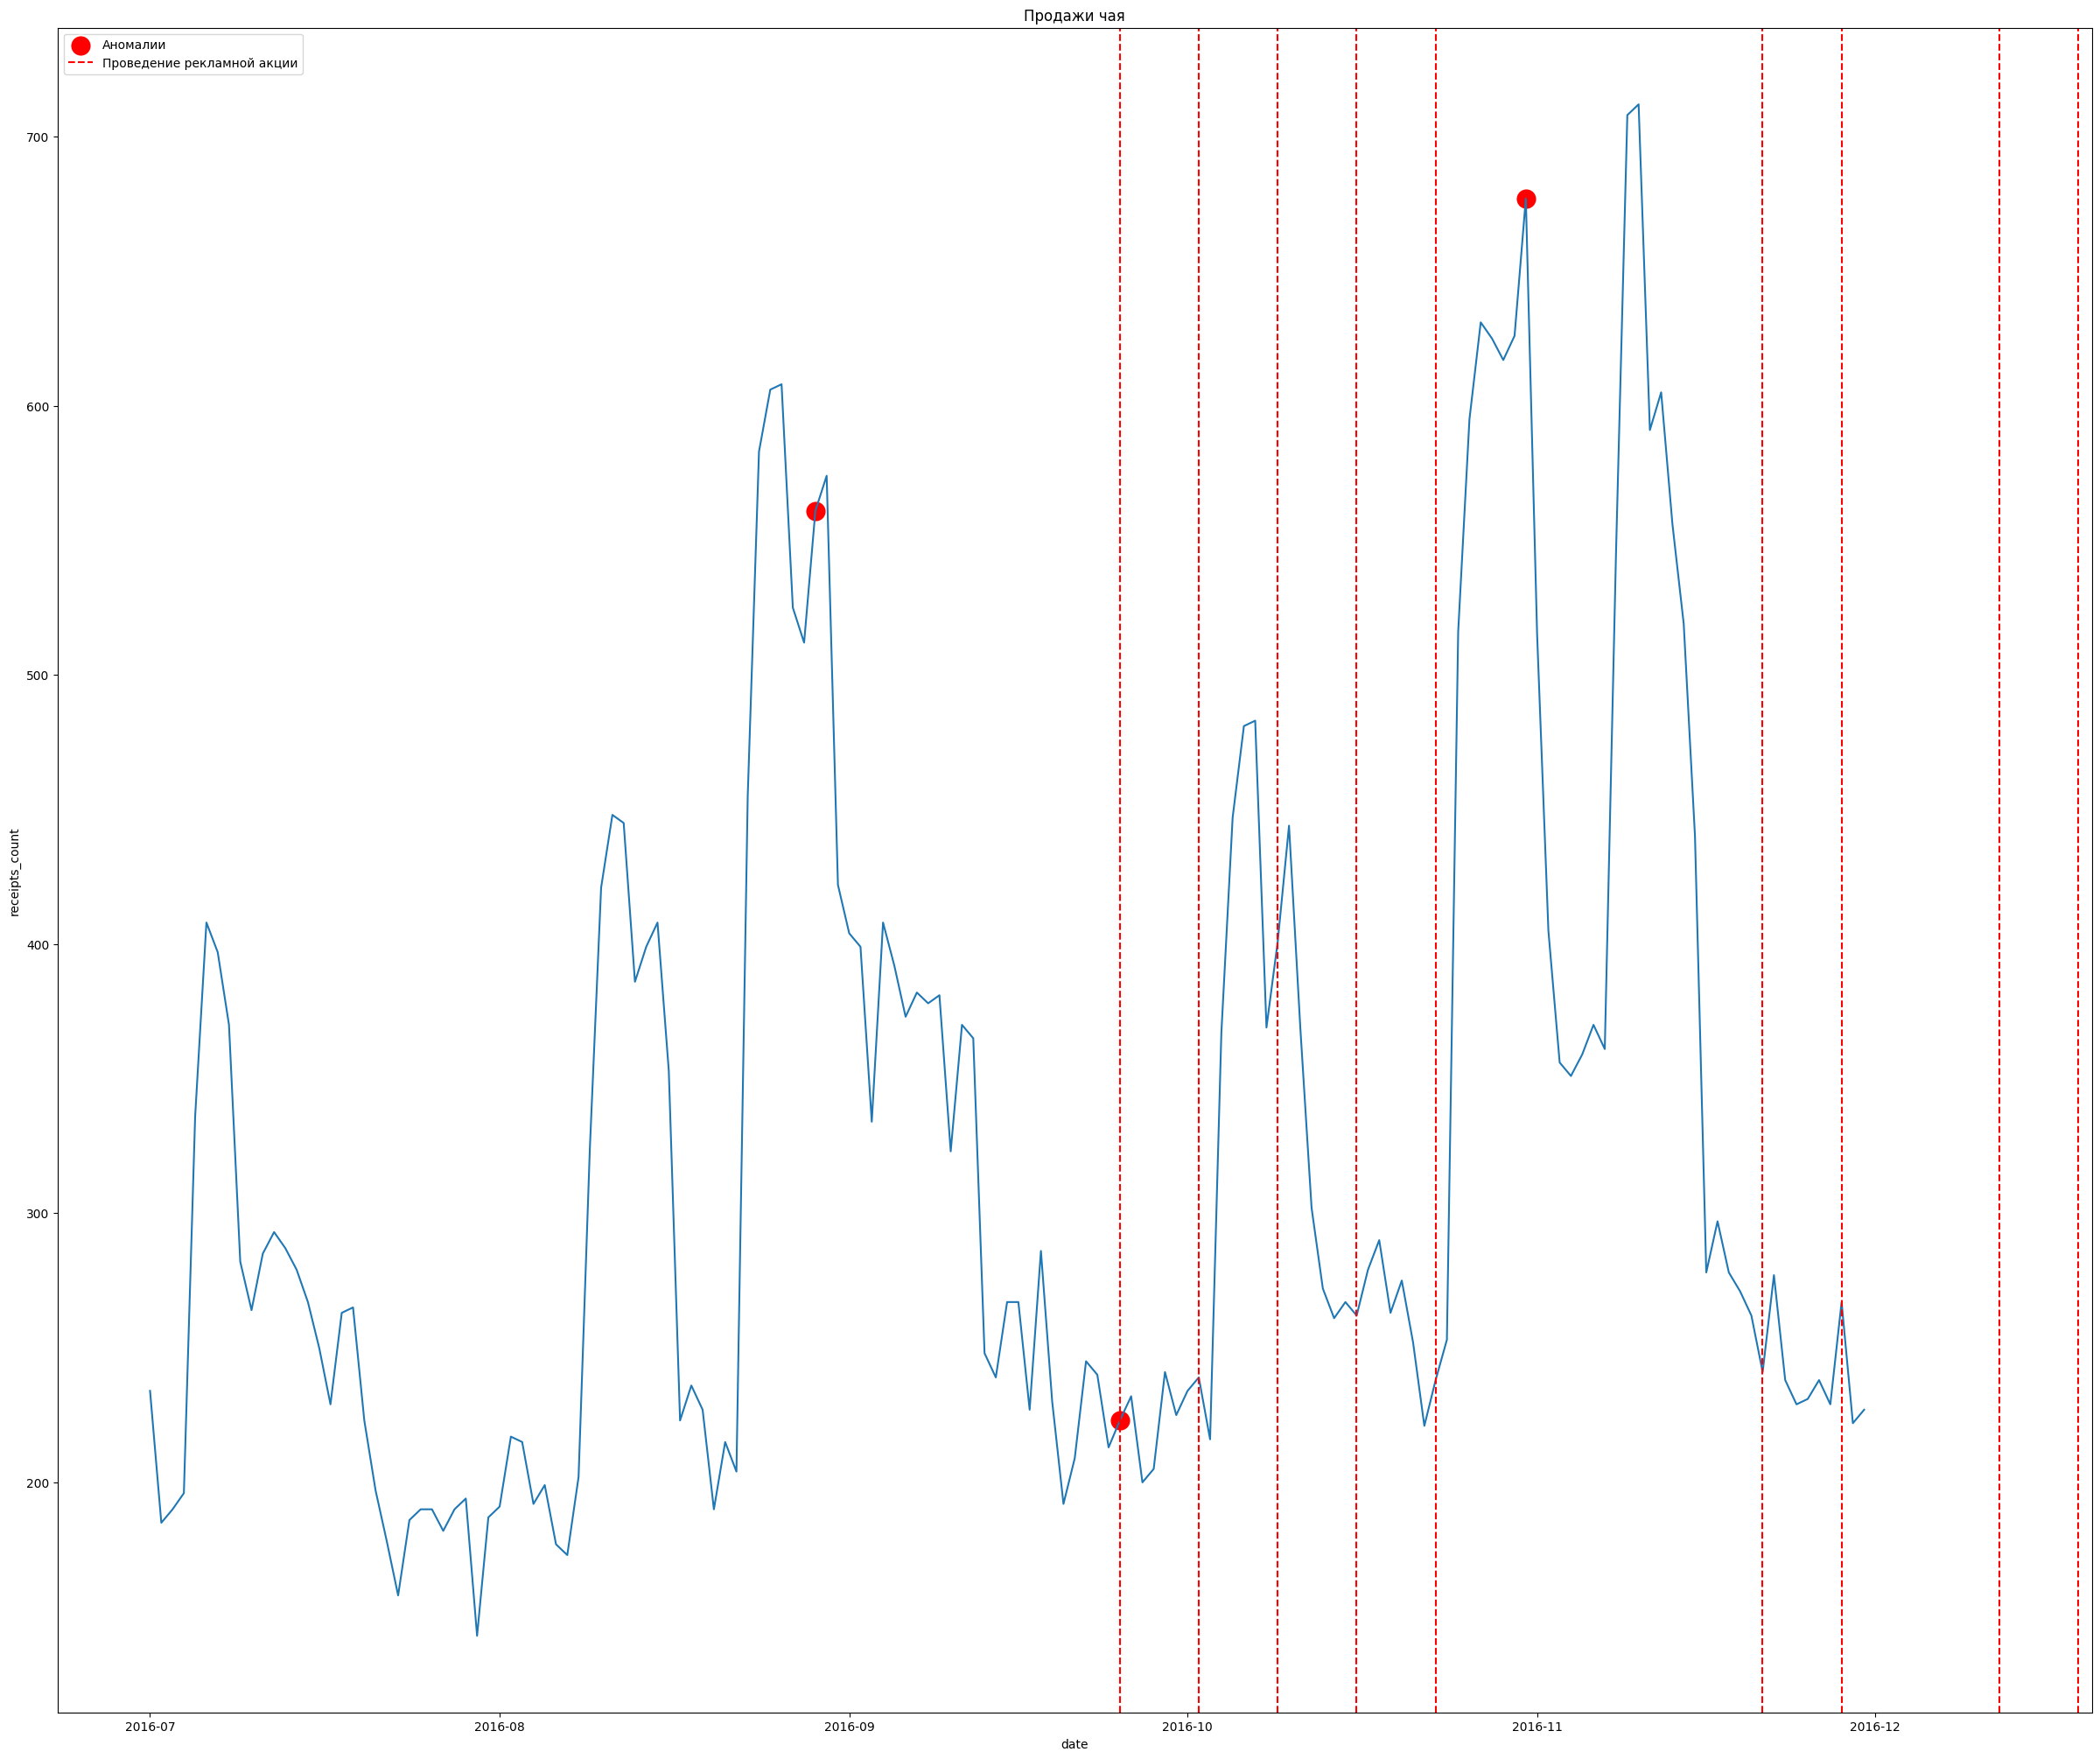

In [158]:
fig, axes = plt.subplots(1, 1, figsize=(30, 25))

sns.lineplot(data=data, x="date", y="receipts_count")

sns.scatterplot(
    data=outliers, x="date", y="receipts_count", c="red", s=300, label="Аномалии"
)


# Построим линии пересечения на основе данных по показу Что, Где, Когда.
lines = []
for i in programs_date["date"]:
    line = axes.axvline(x=i, color="red", linestyle="--")
    lines.append(line)

# Добавление легенды
handles, labels = axes.get_legend_handles_labels()
handles.extend(lines)
labels.extend(["Проведение рекламной акции"])
axes.legend(handles, labels, loc="best")

# Добавление названия к графику
axes.set_title("Продажи чая")


plt.show()

> Из трех аномалий, в интересующий нас интервал попала лишь одна, что частично подтверждает первоначальную гипотезу.

----

### Проведем кластерзацию конкурентов, предположение в том, что если у них не будет аномалий в интересующем нас коридоре, то это станет еще одним доводом в копилку предположения о том что интеграции повляила на рост продаж.

In [159]:
lipton = data_raw.query("brand_id == 29").reset_index(drop=True)
ahmad = data[["date", "receipts_count", "DBSCAN_on_PCA"]]
may = data_raw.query("brand_id == 5152").reset_index(drop=True)

lipton.drop(["brand_id"], axis=1, inplace=True)
may.drop(["brand_id"], axis=1, inplace=True)

display(lipton.head(), may.head())

,date,receipts_count
0,2016-07-01,622
1,2016-07-02,580
2,2016-07-03,687
3,2016-07-04,550
4,2016-07-05,529


,date,receipts_count
0,2016-07-01,98
1,2016-07-02,87
2,2016-07-03,105
3,2016-07-04,141
4,2016-07-05,137


In [160]:
lipton_clus = lipton.copy()
may_clus = may.copy()

# Сформируем фичи от даты
lipton_clus["day_of_week"] = lipton_clus["date"].dt.dayofweek
lipton_clus["quarter"] = lipton_clus["date"].dt.quarter

may_clus["day_of_week"] = may_clus["date"].dt.dayofweek
may_clus["quarter"] = may_clus["date"].dt.quarter

lipton_clus = lipton_clus.set_index("date")
may_clus = may_clus.set_index("date")

display(lipton_clus.head(), may_clus.head())

,receipts_count,day_of_week,quarter
date,,,
2016-07-01,622,4,3
2016-07-02,580,5,3
2016-07-03,687,6,3
2016-07-04,550,0,3
2016-07-05,529,1,3


,receipts_count,day_of_week,quarter
date,,,
2016-07-01,98,4,3
2016-07-02,87,5,3
2016-07-03,105,6,3
2016-07-04,141,0,3
2016-07-05,137,1,3


In [161]:
# Нормализуем наши данные для липтона
starrd_scaler = StandardScaler().fit(lipton_clus)
np_scaled = starrd_scaler.transform(lipton_clus)
lipton_clus = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
lipton_clus = pca.fit_transform(lipton_clus)

min_max_scaler = StandardScaler().fit(lipton_clus)
np_scaled = min_max_scaler.transform(lipton_clus)
lipton_clus = pd.DataFrame(np_scaled)


In [162]:
# Нормализуем наши данные для липтона
starrd_scaler = StandardScaler().fit(may_clus)
np_scaled = starrd_scaler.transform(may_clus)
may_clus = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
may_clus = pca.fit_transform(may_clus)

min_max_scaler = StandardScaler().fit(may_clus)
np_scaled = min_max_scaler.transform(may_clus)
may_clus = pd.DataFrame(np_scaled)


In [163]:
display(lipton_clus.head(), may_clus.head())

,0,1
0,0.630813,-0.557437
1,0.445697,-1.062195
2,0.860294,-1.536256
3,0.405297,1.412151
4,0.304704,0.911719


,0,1
0,-0.825159,0.437348
1,-0.903946,0.933877
2,-0.827246,1.432898
3,-0.515373,-1.548855
4,-0.556629,-1.051725


prediction_dbscan
 0    93
 1    52
-1     8
Name: count, dtype: int64

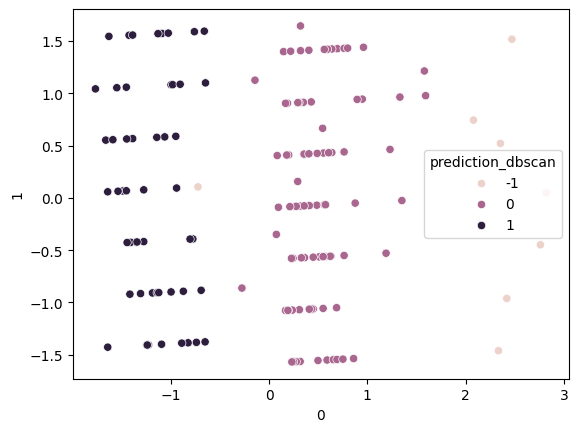

In [164]:
# Найдем аномалии используя DBSCAN для липтона и присвоим лэйблы
dbscan = DBSCAN(eps=0.5)

# Вызовем фитпредикт на вытянутом в столбец векторе значений
lipton_clus["prediction_dbscan"] = dbscan.fit_predict(np.array(lipton_clus))

display(lipton_clus["prediction_dbscan"].value_counts())

lipton["DBSCAN_on_PCA"] = lipton_clus["prediction_dbscan"]

sns.scatterplot(data=lipton_clus, x=0, y=1, hue="prediction_dbscan")
plt.show()

prediction_dbscan
 0    92
 1    60
-1     1
Name: count, dtype: int64

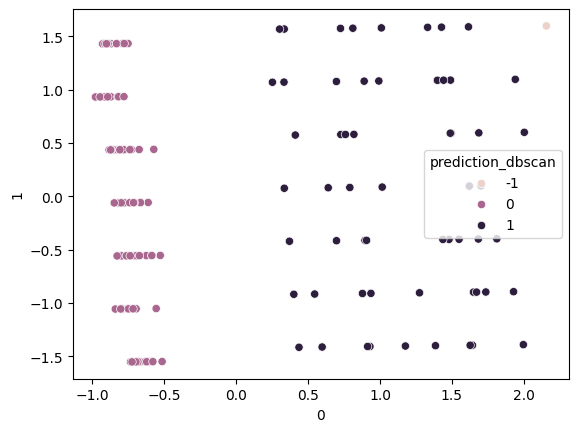

In [165]:
# Найдем аномалии используя DBSCAN для майского и присвоим лэйблы
dbscan = DBSCAN(eps=0.5)

# Вызовем фитпредикт на вытянутом в столбец векторе значений
may_clus["prediction_dbscan"] = dbscan.fit_predict(np.array(may_clus))

display(may_clus["prediction_dbscan"].value_counts())

may["DBSCAN_on_PCA"] = may_clus["prediction_dbscan"]

sns.scatterplot(data=may_clus, x=0, y=1, hue="prediction_dbscan")
plt.show()

In [166]:
# Выделим аномалии для всех конкурентов
outliers_lipton = lipton[lipton["DBSCAN_on_PCA"] < 0]
outliers_lipton = outliers_lipton[["date", "receipts_count"]]

outliers_may = may[may["DBSCAN_on_PCA"] < 0]
outliers_may = outliers_may[["date", "receipts_count"]]

outliers_ahmad = ahmad[ahmad["DBSCAN_on_PCA"] < 0]
outliers_ahmad = outliers_ahmad[["date", "receipts_count"]]

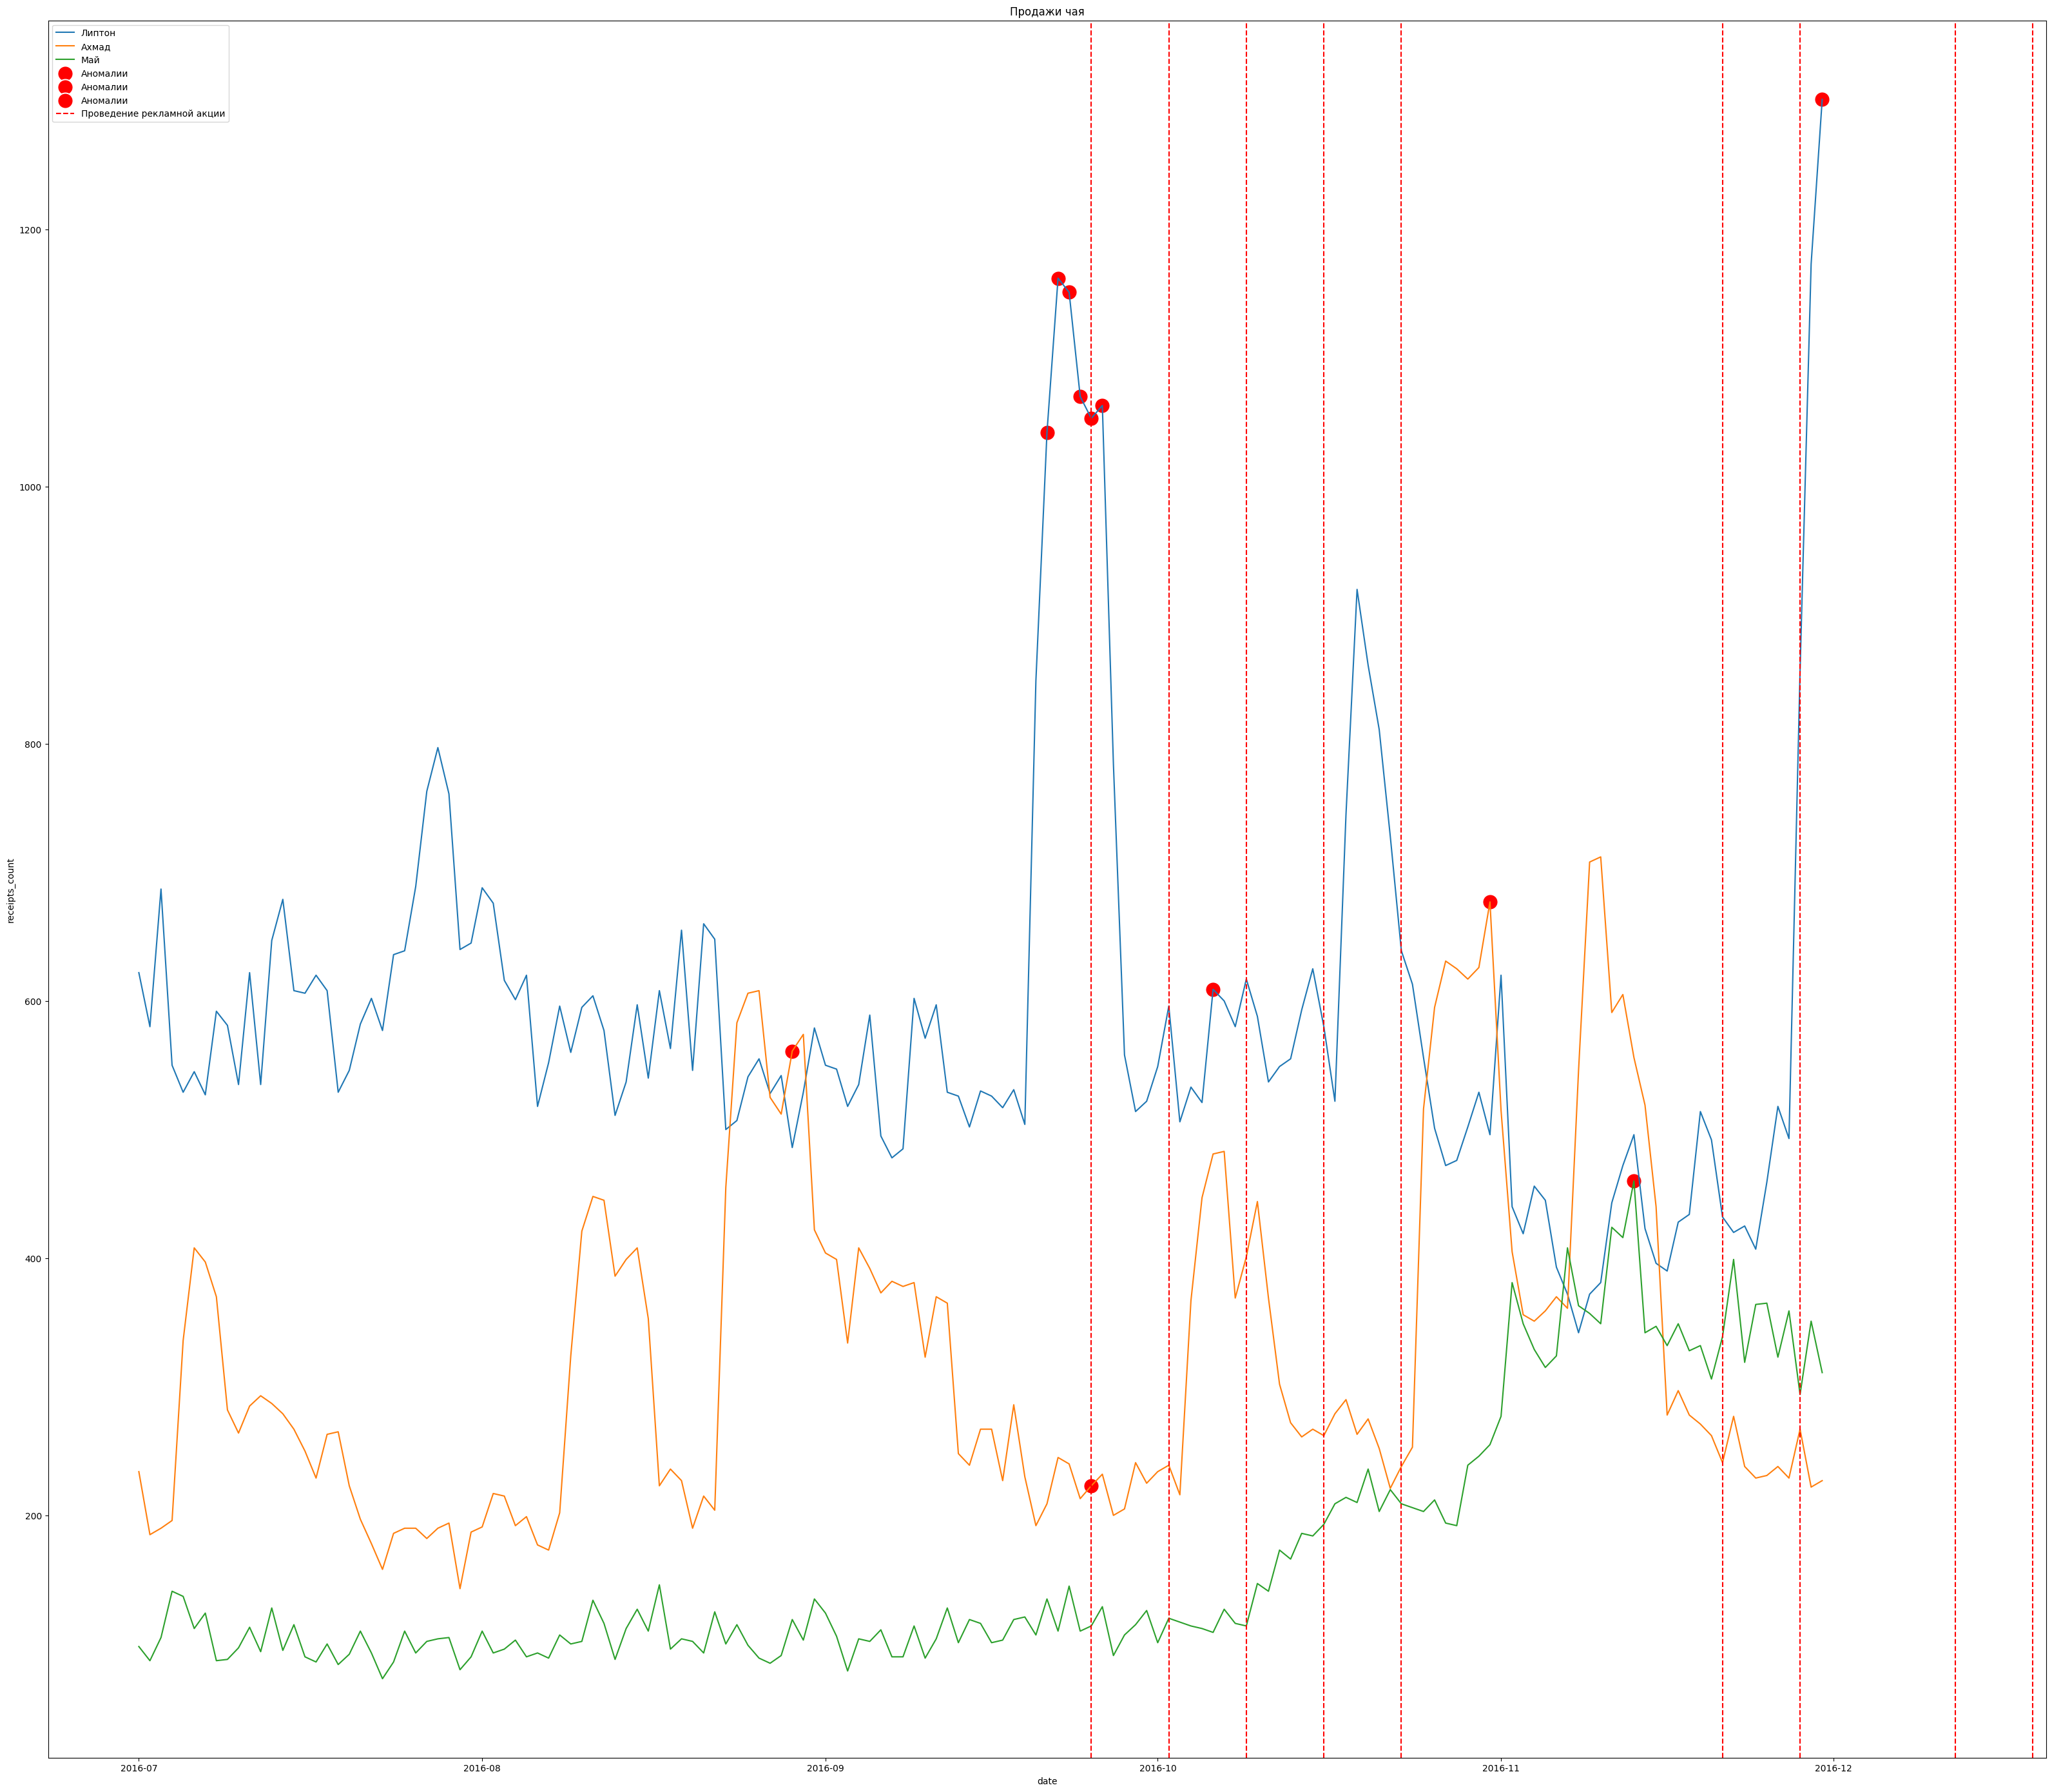

In [167]:
# Построим комбинированный график 
fig, axes = plt.subplots(1, 1, figsize=(40, 35))

sns.lineplot(data=lipton, x="date", y="receipts_count", label="Липтон")
sns.lineplot(data=ahmad, x="date", y="receipts_count", label= "Ахмад")
sns.lineplot(data=may, x="date", y="receipts_count", label="Май")


# Отметим точки аномалии
sns.scatterplot(
    data=outliers_lipton, x="date", y="receipts_count", c="red", s=300, label="Аномалии"
)

sns.scatterplot(
    data=outliers_may, x="date", y="receipts_count", c="red", s=300, label="Аномалии"
)

sns.scatterplot(
    data=outliers_ahmad, x="date", y="receipts_count", c="red", s=300, label="Аномалии"
)


# Построим линии пересечения на основе данных по показу Что, Где, Когда.
lines = []
for i in programs_date["date"]:
    line = axes.axvline(x=i, color="red", linestyle="--")
    lines.append(line)

# Добавление легенды
handles, labels = axes.get_legend_handles_labels()
handles.extend(lines)
labels.extend(["Проведение рекламной акции"])
axes.legend(handles, labels, loc="best")

# Добавление названия к графику
axes.set_title("Продажи чая")


plt.show()

> В интересующем нас диапазоне имеется аномалия у чая Майский, чтож подумаем является ли это признаком того что в данный временной промежуток, который мы обозначили за референс влияния интеграции имело место быть влияние внещнего фактора, который повлиял на всех игроков рынка, и интересующая нас рекламная акция не имела влияния.

> Проведем статтест на корреляцию между брендами.

In [168]:
# Предположим, что у вас есть три выборки
x1 = np.array(lipton["receipts_count"])
x2 = np.array(ahmad["receipts_count"])
x3 = np.array(may["receipts_count"])

# Вычисляем коэффициент корреляции Пирсона между каждой парой выборок
r12 = round(pearsonr(x1, x2)[0], 2)
r13 = round(pearsonr(x1, x3)[0],2)
r23 = round(pearsonr(x2, x3)[0],2)

# Проверяем значимость коэффициентов корреляции с помощью p-значений
p12 = pearsonr(x1, x2)[1]
p13 = pearsonr(x1, x3)[1]
p23 = pearsonr(x2, x3)[1]

# Применяем поправку Бонферрони к p-значениям
p12 = p12 * 3
p13 = p13 * 3
p23 = p23 * 3

# Проверяем, меньше ли p-значения 0.05 после поправки
if p12 < 0.05 and p13 < 0.05 and p23 < 0.05:
    print("Гипотеза о корреляции между выборками принимается")
else:
    print("Гипотеза о корреляции между выборками отвергается")
    
print(f"Корреляция между Липтоном и Ахмад: {r12}")
print(f"Корреляция между Липтоном и Майским: {r13}")
print(f"Корреляция между Ахмад и Майским: {r23}")
    


Гипотеза о корреляции между выборками принимается
Корреляция между Липтоном и Ахмад: -0.39
Корреляция между Липтоном и Майским: -0.25
Корреляция между Ахмад и Майским: 0.29


> Что можно сказать исходя из полученных данных:
> 1. Существует корреляция между продажами разных брендов, что может говорить как о симметричной маркетинговой политике, так и о влиянии внешних рыночных факторов.
> 2. Липтон являющийся лидером рынка напрямую конкурирует как с Ахмад, так и с Майским это выражено в знаке коэфициента корреляции. Т.е. Липтон это субститут брендам Ахмад и Майский. В свою очередь Ахмад и Майский комплементы.
> 3. Во всех трех случаях корреляция достаточно слабая, что может говорить о наличии аномалий в интересующем временном периоде у Ахмад и Майский, как о не связанных выбросах. Подтвердить эту гипотезу можно попробовав смоделировать прогноз для Майского чая и посмотреть сильно ли модельное предсказание по нему отходит от факта, если модель покажет не большое отклонение, то можно предположить, что аномалии Майского чая маловероятно связаны с Ахмад.

----

### ARIMA для майского чая

In [224]:
ts_may = may[["date", "receipts_count"]]
ts_may.set_index('date', inplace=True)


In [225]:
# Немного срежем углы и определим что для дальнейших манипуляций d = 1
adfuller_test(ts_may.diff().dropna(), "receipts_count")
d=1

adf:  -5.929372822673353
p-value:  2.400856015479292e-07
Critical values:  {'1%': -3.4756368462466662, '5%': -2.8814104466172608, '10%': -2.5773652982553568}
ряд стационарен


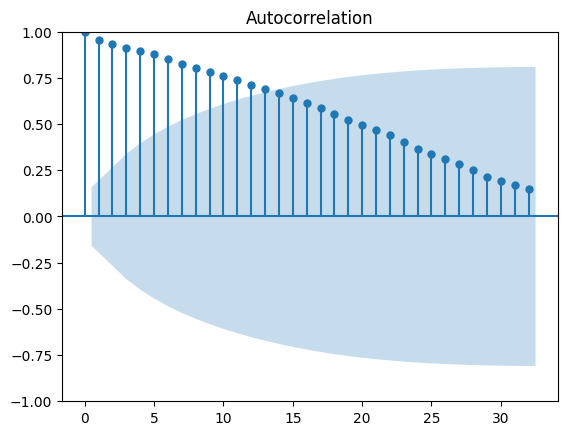

In [226]:
# Посмотрим на график автрокорреляции для выделение компоненты q.
# q = 28
sm.graphics.tsa.plot_acf(ts_may["receipts_count"], lags=32)
q = 30
plt.show()

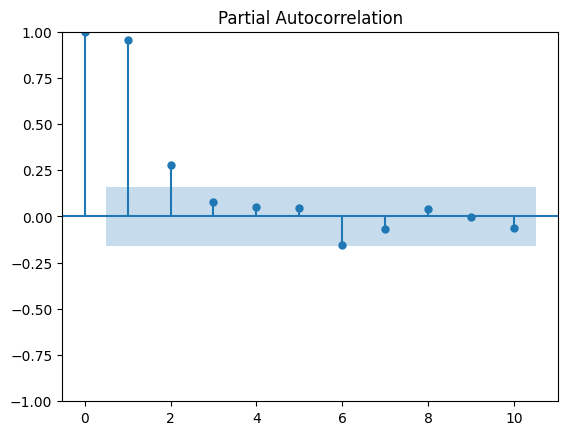

In [227]:
# Посмотрим на график частичной автрокорреляции для выделение компоненты p.
# p = 2
sm.graphics.tsa.plot_pacf(ts_may["receipts_count"], lags=10)
p = 2
plt.show()

In [228]:
# Выделим границы проведения акции-программы что бы в дальнейшем
# использовать для формирования трейн/теста
adv_prog_periods = data["date"][data["programm_factor"] == True]
split_list = [i for i in adv_prog_periods]
ts_may.reset_index(inplace=True)


In [229]:
# Инициализация пустого датафрейма
prognosis_df = pd.DataFrame()

# Наполнение датафрейма прогнозными интервалами
for i in range(len(split_list)):
    try:
        train = ts_may[ts_may["date"] < split_list[i]]
        test = ts_may[(ts_may["date"] >= split_list[i]) & (ts_may["date"] < split_list[i+1])]

        y_train = train.set_index("date")["receipts_count"]
        y_test = test.set_index("date")["receipts_count"]
        
        model = ARIMA(y_train.values.reshape(-1), order=(p,d,q))
        
        arima_predictions = model.fit().predict(
            start=len(y_train),
            end=len(y_train)+len(y_test) -1,  
            dynamic=False)
        
        result = pd.DataFrame(arima_predictions, index=y_test.index, columns=["arima_predictions"])
        
        prognosis_df = pd.concat([prognosis_df, result], axis=0)
    except IndexError:
        pass

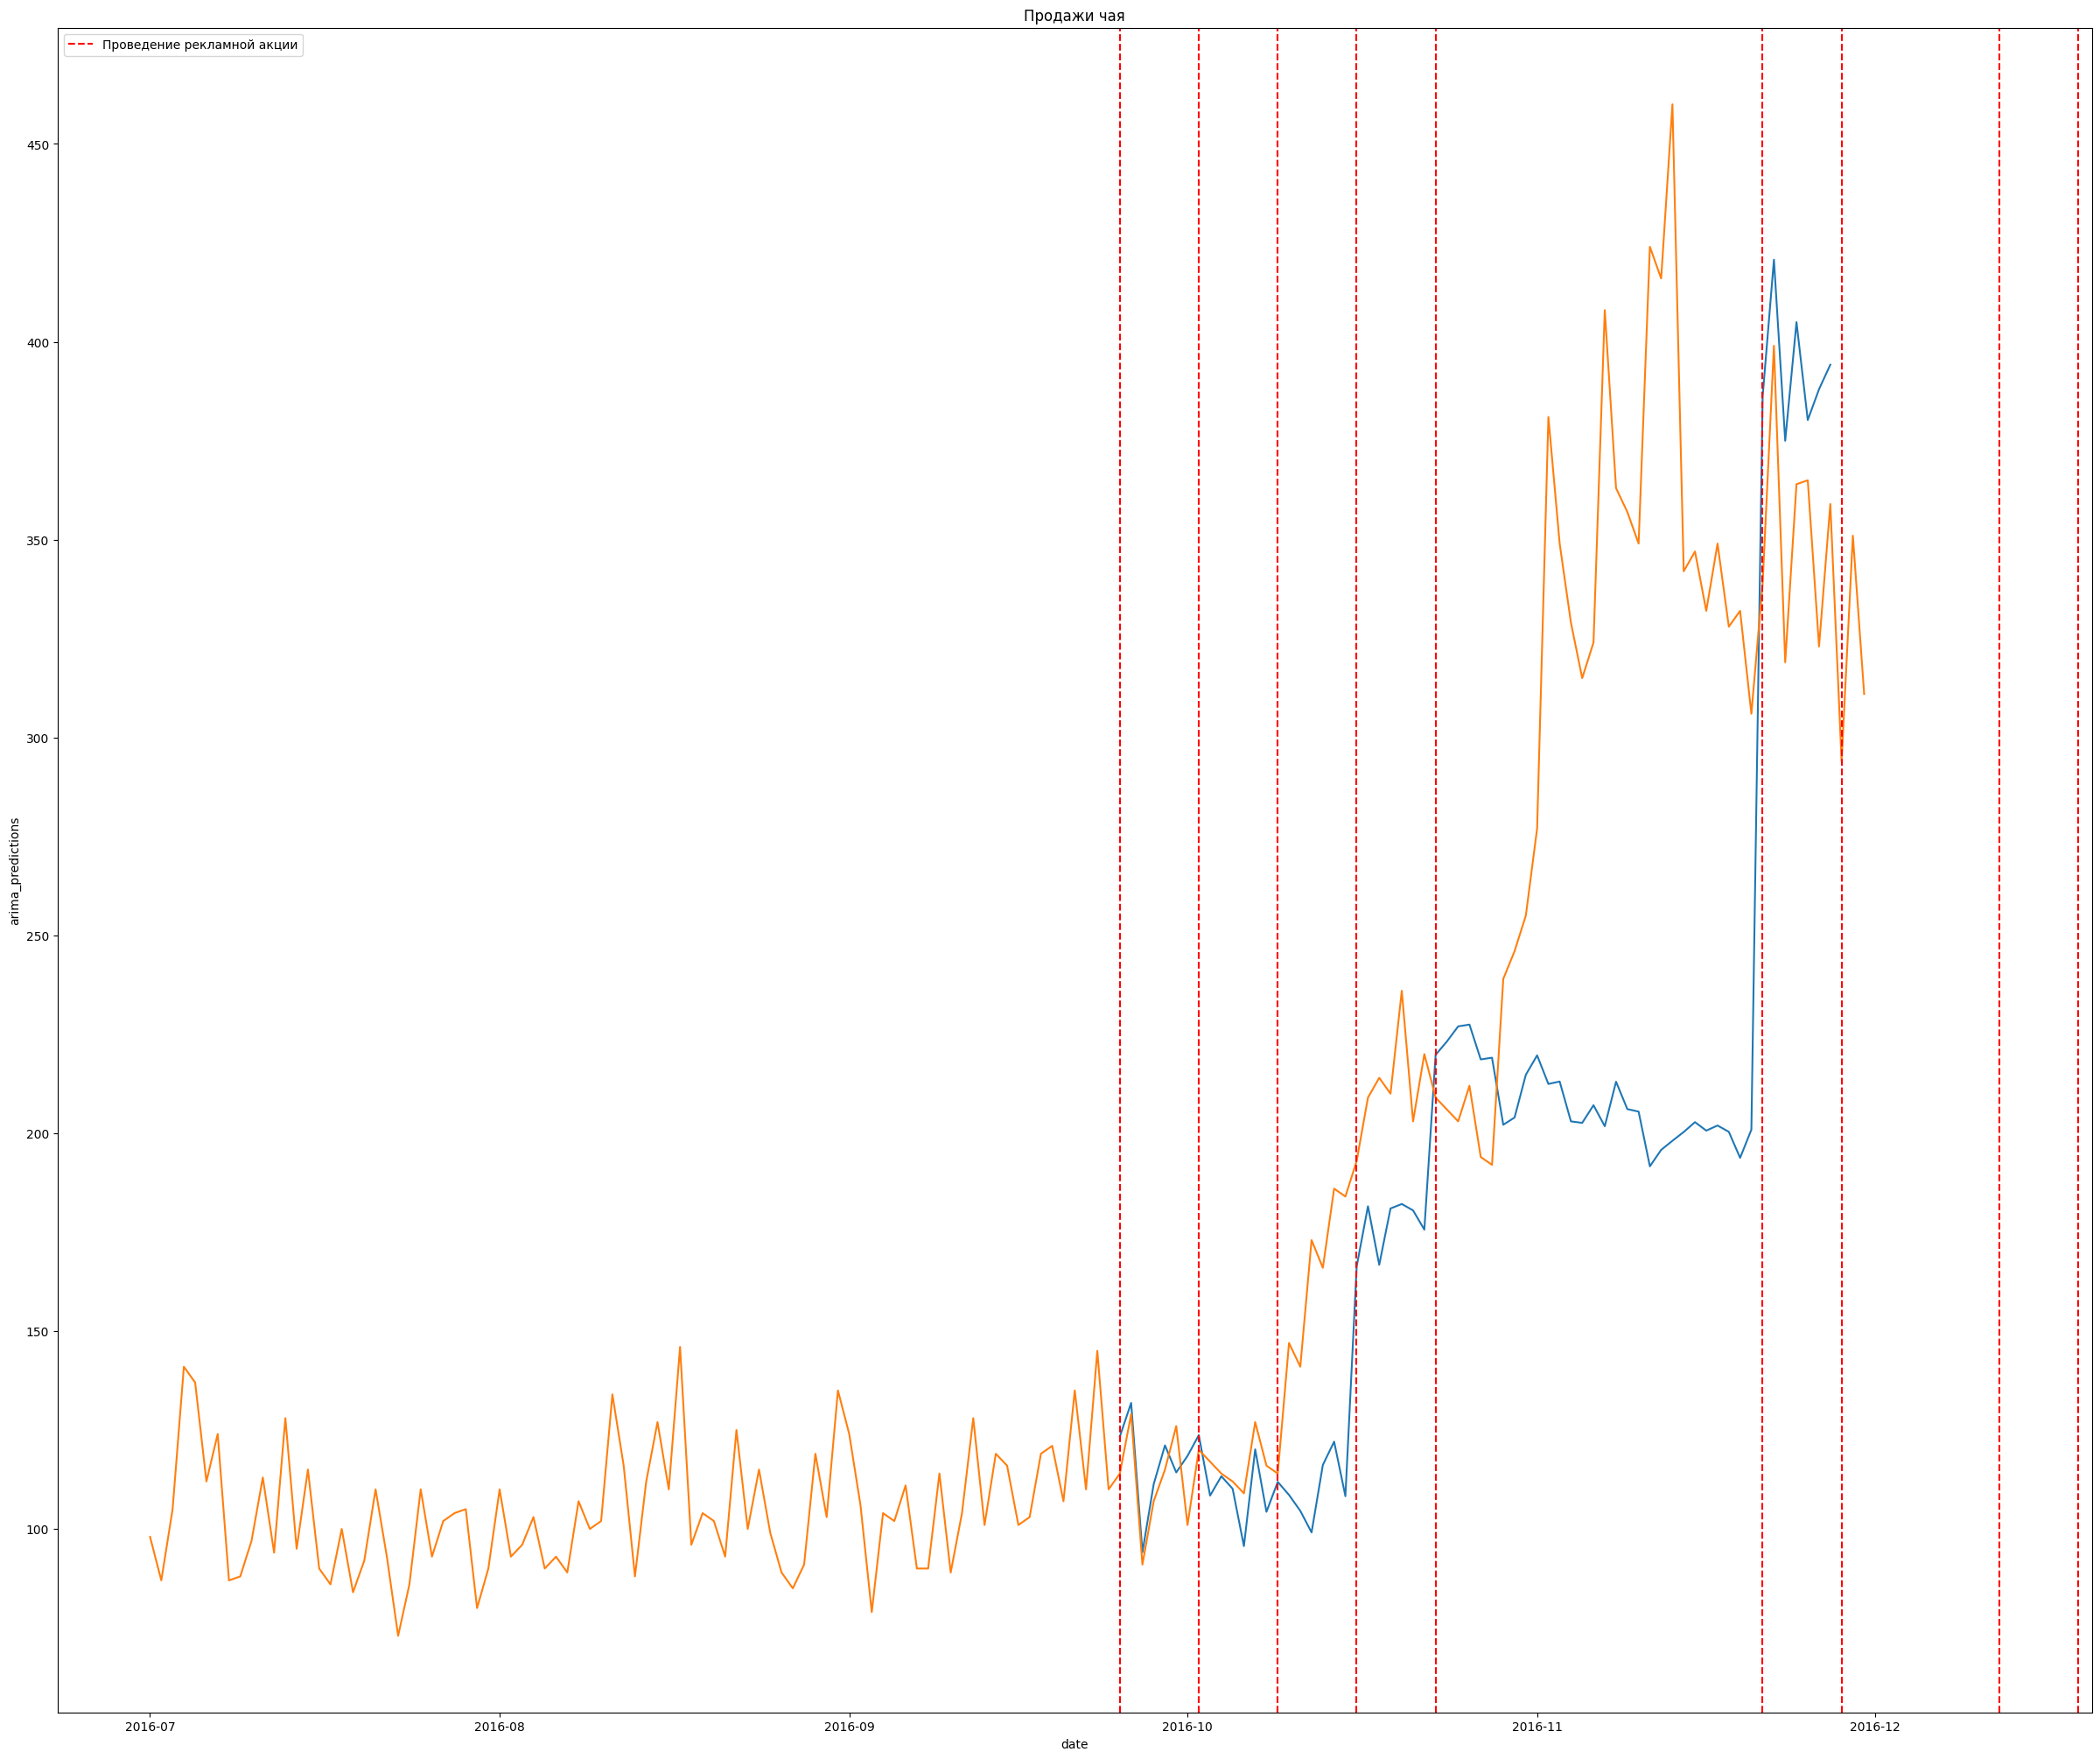

In [230]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

sns.lineplot(data=prognosis_df, x="date", y="arima_predictions", ax=axes)
sns.lineplot(x=ts_may["date"], y=ts_may["receipts_count"], ax=axes)

# Построим линии пересечения на основе данных по показу Что, Где, Когда.
lines = []
for i in programs_date["date"]:
    line = axes.axvline(x=i, color="red", linestyle="--")
    lines.append(line)

# Добавление легенды
handles, labels = axes.get_legend_handles_labels()
handles.extend(lines)
labels.extend(["Проведение рекламной акции"])
axes.legend(handles, labels, loc='best')

# Добавление названия к графику
axes.set_title("Продажи чая")

plt.show()

> У Майского так же присутствует аномальная активность в интересующей нас зоне, что увеличивает вероятность того что и на Ахмад повлияла не интеграция, а некий иной внешний фактор имеющий схожее воздействие на комлиментарный товар.

---
### Linear Regression для майского

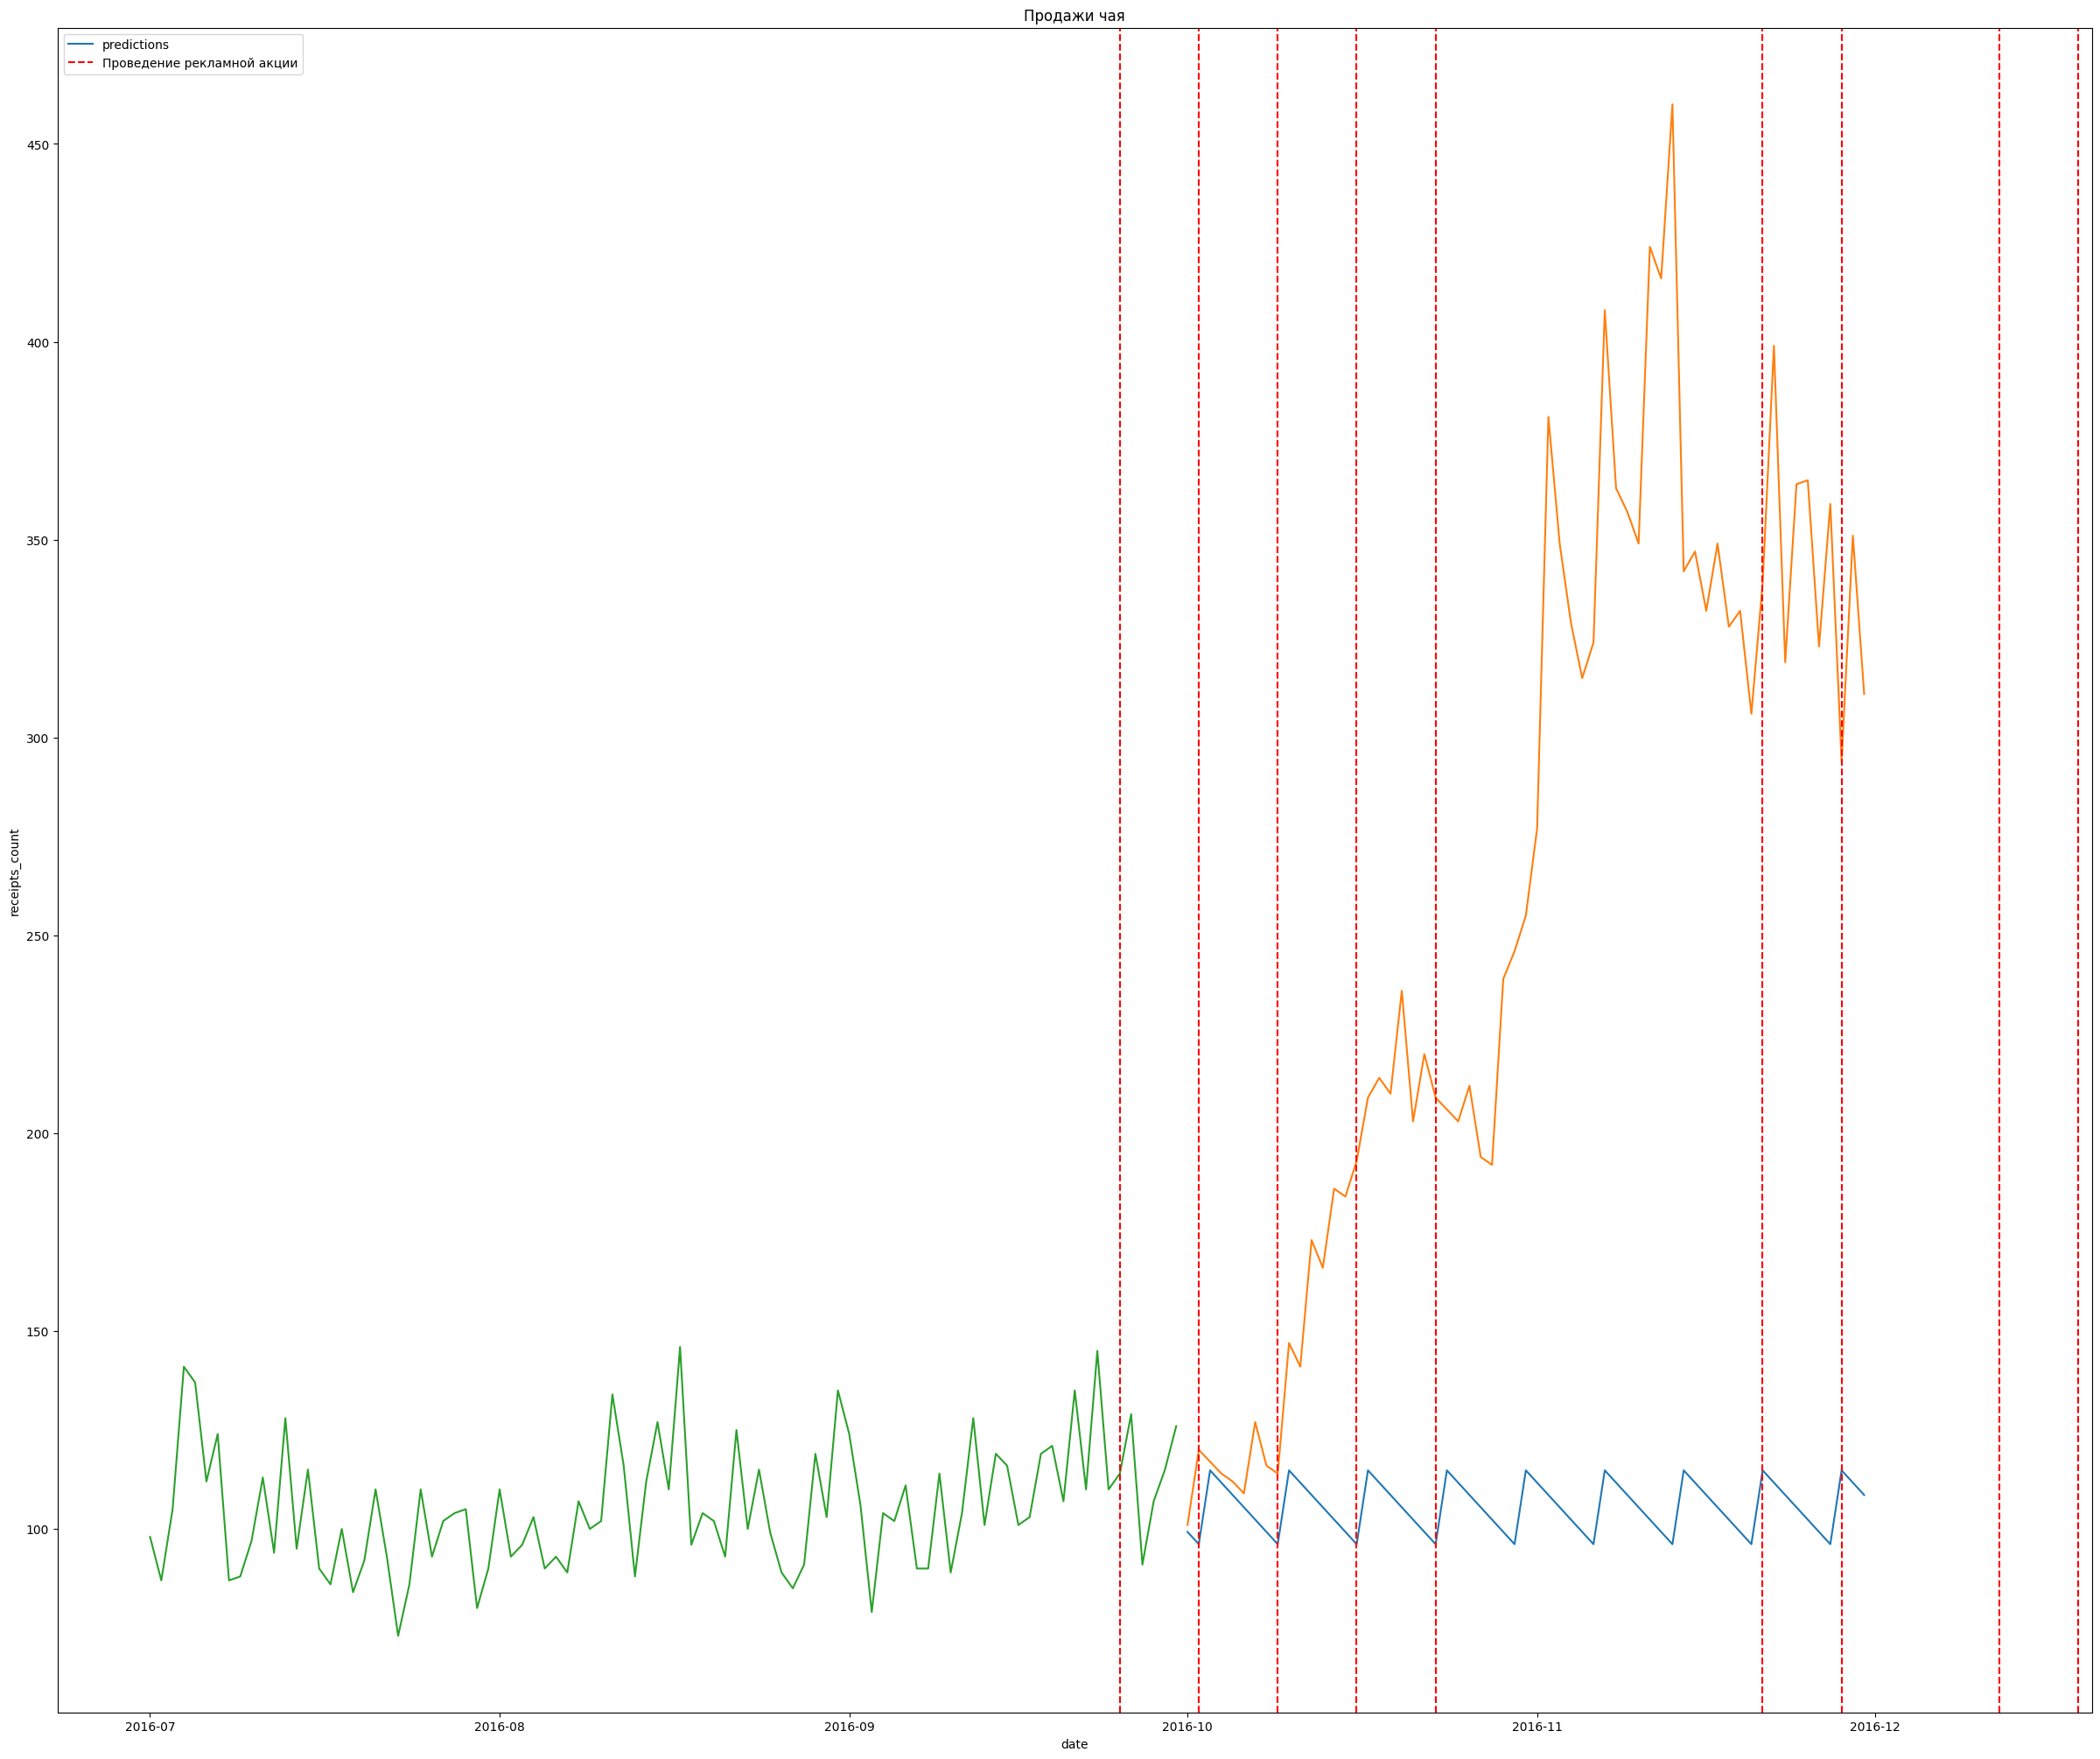

In [234]:
may_lr = ts_may.copy()

# Сформируем фичи от даты
may_lr["day_of_week"] = may_lr["date"].dt.dayofweek

may_lr["quarter"] = may_lr["date"].dt.quarter


# Пробуем спрогнозировать линейной регрессией 
test = may_lr[may_lr["date"].dt.month > 9].set_index("date")
train = may_lr[may_lr["date"].dt.month <= 9].set_index("date")

# Сформируем трейн/тест
test = test[
    ["day_of_week", "quarter", "receipts_count"]
]

train = train[
    ["day_of_week", "quarter", "receipts_count"]
]

X_train = train.drop(["receipts_count"], axis=1)
y_train = train["receipts_count"]

X_test = test.drop(["receipts_count"], axis=1)
y_test = test["receipts_count"]

# Начинаем моделировать
model = LinearRegression()

model.fit(X_train, y_train)

prediction = model.predict(X_test)

prediction = pd.DataFrame(prediction, index=y_test.index, columns=["predictions"])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

sns.lineplot(prediction, ax=axes,) 
sns.lineplot(y_test, ax=axes,)
sns.lineplot(y_train, ax=axes,)

# Построим линии пересечения на основе данных по показу Что, Где, Когда.
lines = []
for i in programs_date["date"]:
    line = axes.axvline(x=i, color="red", linestyle="--")
    lines.append(line)

# Добавление легенды
handles, labels = axes.get_legend_handles_labels()
handles.extend(lines)
labels.extend(["Проведение рекламной акции"])
axes.legend(handles, labels, loc='best')

# Добавление названия к графику
axes.set_title("Продажи чая")

plt.show()


> Линейная регрессия так же отметила аномальность данного периода, что довольно хорошо видно на графике, можно сказать, что визуально до момента 10 месяца ряд Майского чая был стационарен. Но нужно отметить, что в отличие от чая Ахмад, Майский не испытал того же драматического падения после интересующего нас периода.

-----
## Общий вывод

### Исходя из проведенного исследования можно сделать следующие выводы:

1. В период проведения рекламной акции действительно наблюдается аномальное отклонение в продажах чая Ахмад.

2. Так же имеется аномальный рост за данный период в продажах у комлимента в лице Майского чая, что говорит о том, что вероятнее всего имеет место быть синхронное влияние неучтенного фактора помимо рекламной интеграции, но надо отметить, что в отличие от Майского, у Ахмада не произошла стабилизация уровня продаж, а произошел возврат к доанамальному периоду, что выглядит как вероятная инъекция положительного влияния интеграции.

3. Статистические методы, на ряду с прогнозами ML-моделей (а точнее сильное расхождение от факта) и кластеризацией, показывают один и тот же аномальный период, который по логике как раз попадает на период накопительного эффекта от интеграции.

4. В разрезе имеющихся данных, можно заключить, для однозначного ответа на вопрос имеет ли влияние внедрение интеграции на рост продаж, без понимания какого рода экзогенный фактор повлиял на рост продаж конкурента, мы дать не можем, ХОТЯ и ВЕРОЯТНО, положительное влияние интеграции имеет место быть, хоть и сложно оценить точный уровень ее влияния.